# Modules & Dataset loading

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.callbacks.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


In [88]:
category = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
train = pd.read_csv('../data/sales_train_v2.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sample_submission.csv')

# Data Exploration

Lets look at some of the data sample

In [3]:
print("Data Samples\n")
print("Sample submission")
print(sample.head())
print("\n==================================")
print("==================================\n")
print("Train")
print(train.head())
print("\n==================================")
print("==================================\n")
print("Test")
print(test.head())
print("\n==================================")
print("==================================\n")
print("Category")
print(test.head())
print("\n==================================")
print("==================================\n")
print("Items")
print(test.head())
print("\n==================================")
print("==================================\n")
print("Shop")
print(test.head())

Data Samples

Sample submission
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5


Train
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


Test
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


Category
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


Items
   ID  shop_id  item_id
0   0        5     5037
1   1        5     532

In [4]:
print("\t\trows\tcolumns")
print(f"Train\t\t{train.shape[0]}\t{train.shape[1]}")
print(f"Test\t\t{test.shape[0]}\t{test.shape[1]}")
print(f"Items\t\t{items.shape[0]}\t{items.shape[1]}")
print(f"Shops\t\t{shops.shape[0]}\t{shops.shape[1]}")
print(f"Category\t{category.shape[0]}\t{category.shape[1]}")

		rows	columns
Train		2935849	6
Test		214200	3
Items		22170	3
Shops		60	2
Category	84	2


Pay attention to test samples, that will be our input later on once we finish with our modeling. That means we should be expecting input with the same shapes and features

In [5]:
category_item = items.join(category.set_index('item_category_id'), on='item_category_id')

In [6]:
category_item.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                    item_category_name  
0                40                            Кино - DVD  
1                76  Программы - Для дома и офиса (Цифра)  
2                40                            Кино - DVD  
3                40                            Кино - DVD  
4                40                            Кино - DVD

I combined dataframe to get the name because it will give more information when we plot graph later on.

In [7]:
category_item

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id                    item_category_name  
0                    40                            Кино - DVD  
1                    76  Программы - Для дома и офиса (Цифра)  
2                    40                            Кино - DVD  
3                    40                            Кино - DVD  
4                    40                            Кино - DVD  
...                 ...                                   ...  
22165                31                       Игры PC - Цифра  
22166                54                         Книги - Цифра  
22167                49     Книги - Методические материалы 1С  
22168                62      Подарки - Гаджеты, роботы, спорт  
22169                69                    Подарки - Сувениры  

[22170 rows x 4 columns]

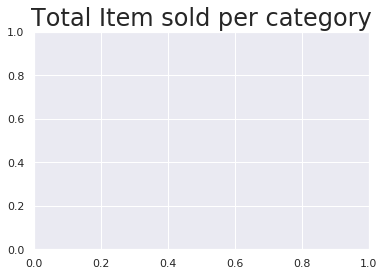

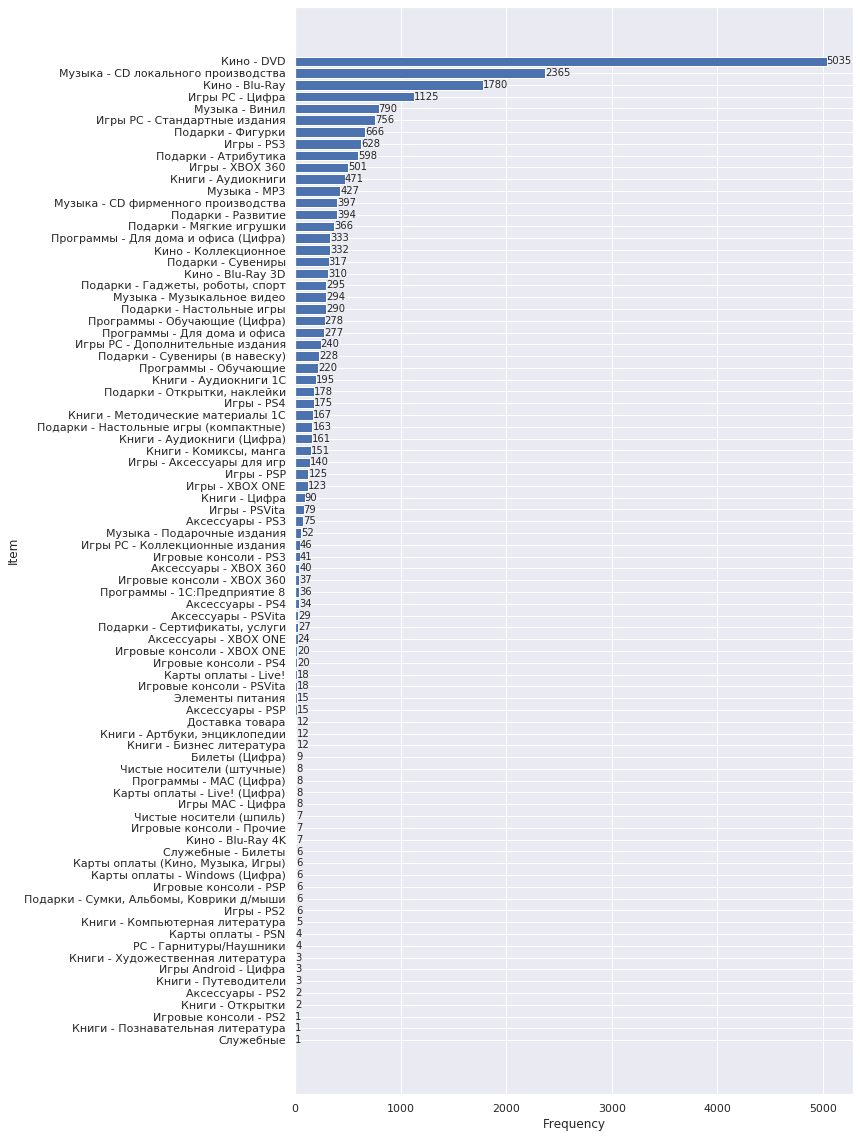

In [8]:
item_counts = category_item.item_category_name.value_counts().sort_values()
x = item_counts.index
y = item_counts.values
plt.title("Total Item sold per category", fontsize=24)
plt.figure(figsize=(10,20))
plt.barh(x,y)
plt.ylabel('Item')
plt.xlabel('Frequency')

for k,j in zip(x,y):
    plt.annotate(str(j), xy=(j, k), va='center')

plt.show()

I did ranking for both shops and categories. The is for the model learn better. The intuition behind it is when it receive higher inputs the model will more likely to learn that the sales is going to be higher. 


In [9]:
#Ranking
cat_ranks = sorted(list(set(item_counts.values)))
print(cat_ranks)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 18, 20, 24, 27, 29, 34, 36, 37, 40, 41, 46, 52, 75, 79, 90, 123, 125, 140, 151, 161, 163, 167, 175, 178, 195, 220, 228, 240, 277, 278, 290, 294, 295, 310, 317, 332, 333, 366, 394, 397, 427, 471, 501, 598, 628, 666, 756, 790, 1125, 1780, 2365, 5035]


In [10]:
cat_rank = {}
for k,v in item_counts.items():
    cat_rank[k] = cat_ranks.index(v)
cat_rank

{'Служебные': 0,
 'Книги - Познавательная литература': 0,
 'Игровые консоли - PS2': 0,
 'Книги - Открытки': 1,
 'Аксессуары - PS2': 1,
 'Книги - Путеводители': 2,
 'Игры Android - Цифра': 2,
 'Книги - Художественная литература': 2,
 'PC - Гарнитуры/Наушники': 3,
 'Карты оплаты - PSN': 3,
 'Книги - Компьютерная литература': 4,
 'Игры - PS2': 5,
 'Подарки - Сумки, Альбомы, Коврики д/мыши': 5,
 'Игровые консоли - PSP': 5,
 'Карты оплаты - Windows (Цифра)': 5,
 'Карты оплаты (Кино, Музыка, Игры)': 5,
 'Служебные - Билеты': 5,
 'Кино - Blu-Ray 4K': 6,
 'Игровые консоли - Прочие': 6,
 'Чистые носители (шпиль)': 6,
 'Игры MAC - Цифра': 7,
 'Карты оплаты - Live! (Цифра)': 7,
 'Программы - MAC (Цифра)': 7,
 'Чистые носители (штучные)': 7,
 'Билеты (Цифра)': 8,
 'Книги - Бизнес литература': 9,
 'Книги - Артбуки, энциклопедии': 9,
 'Доставка товара': 9,
 'Аксессуары - PSP': 10,
 'Элементы питания': 10,
 'Игровые консоли - PSVita': 11,
 'Карты оплаты - Live!': 11,
 'Игровые консоли - PS4': 12,
 'И

In [11]:
shop_item = train.join(shops.set_index('shop_id'), on='shop_id')

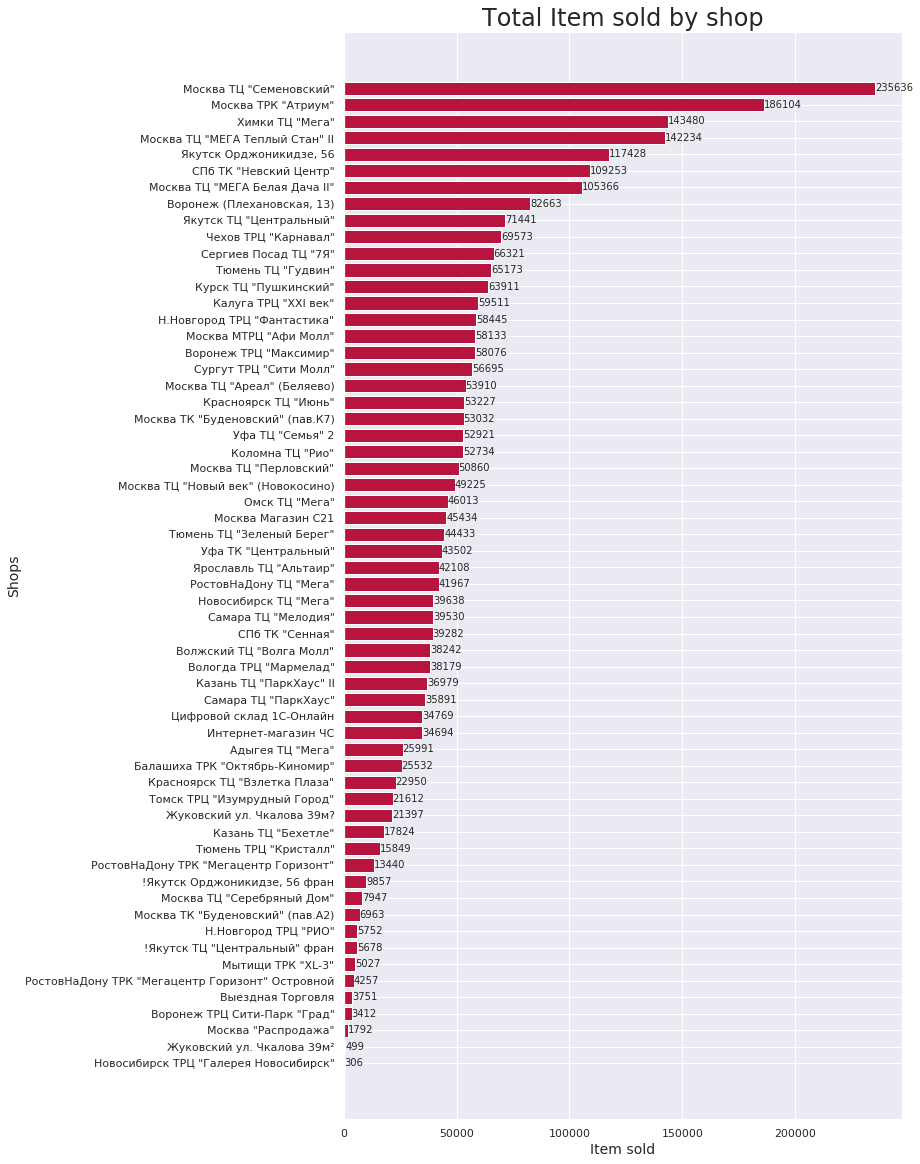

In [12]:
shop_sales = shop_item.shop_name.value_counts().sort_values()
x = shop_sales.index
y = shop_sales.values
plt.figure(figsize=(10,20))
plt.title("Total Item sold by shop", fontsize=24)
plt.barh(x,y, color='#b71540')
plt.ylabel('Shops',fontsize=14)
plt.xlabel('Item sold',fontsize=14)

for k,j in zip(x,y):
    plt.annotate(str(j), xy=(j, k), va='center')

plt.show()

In [13]:
#Ranking
shop_ranks = sorted(list(set(shop_sales.values)))
print(shop_ranks)

[306, 499, 1792, 3412, 3751, 4257, 5027, 5678, 5752, 6963, 7947, 9857, 13440, 15849, 17824, 21397, 21612, 22950, 25532, 25991, 34694, 34769, 35891, 36979, 38179, 38242, 39282, 39530, 39638, 41967, 42108, 43502, 44433, 45434, 46013, 49225, 50860, 52734, 52921, 53032, 53227, 53910, 56695, 58076, 58133, 58445, 59511, 63911, 65173, 66321, 69573, 71441, 82663, 105366, 109253, 117428, 142234, 143480, 186104, 235636]


In [14]:
shop_rank = {}
for k,v in shop_sales.items():
    shop_rank[k] = shop_ranks.index(v)
shop_rank

{'Новосибирск ТРЦ "Галерея Новосибирск"': 0,
 'Жуковский ул. Чкалова 39м²': 1,
 'Москва "Распродажа"': 2,
 'Воронеж ТРЦ Сити-Парк "Град"': 3,
 'Выездная Торговля': 4,
 'РостовНаДону ТРК "Мегацентр Горизонт" Островной': 5,
 'Мытищи ТРК "XL-3"': 6,
 '!Якутск ТЦ "Центральный" фран': 7,
 'Н.Новгород ТРЦ "РИО"': 8,
 'Москва ТК "Буденовский" (пав.А2)': 9,
 'Москва ТЦ "Серебряный Дом"': 10,
 '!Якутск Орджоникидзе, 56 фран': 11,
 'РостовНаДону ТРК "Мегацентр Горизонт"': 12,
 'Тюмень ТРЦ "Кристалл"': 13,
 'Казань ТЦ "Бехетле"': 14,
 'Жуковский ул. Чкалова 39м?': 15,
 'Томск ТРЦ "Изумрудный Город"': 16,
 'Красноярск ТЦ "Взлетка Плаза"': 17,
 'Балашиха ТРК "Октябрь-Киномир"': 18,
 'Адыгея ТЦ "Мега"': 19,
 'Интернет-магазин ЧС': 20,
 'Цифровой склад 1С-Онлайн': 21,
 'Самара ТЦ "ПаркХаус"': 22,
 'Казань ТЦ "ПаркХаус" II': 23,
 'Вологда ТРЦ "Мармелад"': 24,
 'Волжский ТЦ "Волга Молл"': 25,
 'СПб ТК "Сенная"': 26,
 'Самара ТЦ "Мелодия"': 27,
 'Новосибирск ТЦ "Мега"': 28,
 'РостовНаДону ТЦ "Мега"': 29

In [15]:
train_df = train\
            .join(shops.set_index('shop_id'), on='shop_id')\
            .join(category_item.set_index('item_id'), on='item_id')

Now lets dive deeper in exploration. But before that lets transform some of the features so it looks nicer in graph.

In [16]:
def extract_monthyear(date):
    monthyear = datetime.strptime(date, "%d.%m.%Y").date().strftime("%B-%Y")
    return monthyear

train_df['category_rank'] = train_df['item_category_name'].map(cat_rank)
train_df['shop_rank'] = train_df['shop_name'].map(shop_rank)
train_df['month_year'] = train_df.date.apply(extract_monthyear)

In [17]:
train_df.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                shop_name                                 item_name  \
0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)   
1     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP   
2     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP   
3     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP   
4     Москва ТРК "Атриум"   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)   

   item_category_id                   item_category_name  category_rank  \
0                37                       Кино - Blu-Ray             60   
1                58                       Музыка - Винил             58   
2                58                       Музыка - Винил             58   
3                58                       Музыка - Винил             58   
4                56  Музыка - CD фирменного производства             50   

   shop_rank    month_year  
0         30  January-2013  
1         58  January-2013  
2         58  January-2013  
3         58  January-2013  
4         58  January-2013

In [18]:
spm = train.groupby("date_block_num")['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day':'item_cnt_month'})

In [19]:
xlabels = train_df.month_year.unique()
x = spm['date_block_num'].values
y = spm['item_cnt_month'].astype(int).values

In [20]:
mask2013 = ['2013' in month for month in xlabels]
mask2014 = ['2014' in month for month in xlabels]
mask2015 = ['2015' in month for month in xlabels]


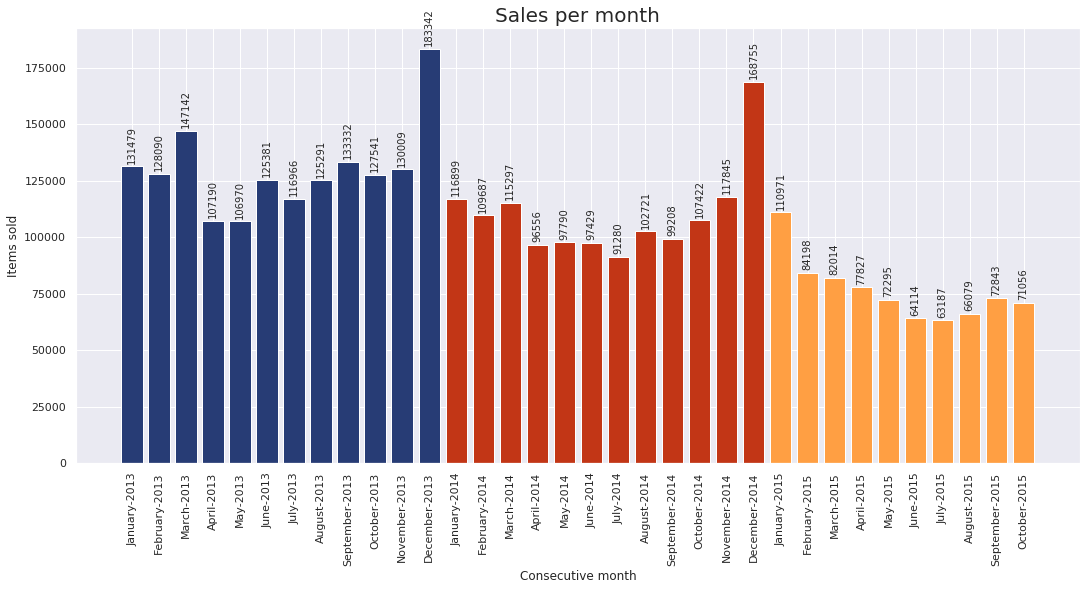

In [21]:
plt.figure(figsize=(18,8))
plt.title('Sales per month',fontsize=20)
plt.bar(x[mask2013], y[mask2013], color='#273c75')
plt.bar(x[mask2014], y[mask2014], color='#c23616')
plt.bar(x[mask2015], y[mask2015], color='#ff9f43')
plt.xticks(x,xlabels,rotation=90)
plt.xlabel('Consecutive month')
plt.ylabel('Items sold')



for k,j in zip(x,y):
    plt.annotate(str(j), xy=(k,j+ 2000), ha='center', rotation=90)
plt.show()

In [22]:
#pattern for each category
cat_by_month = train_df.groupby(['item_category_name','date_block_num'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")
cat_by_month["item_cnt_month"] = cat_by_month["item_cnt_month"].astype(int)

In [23]:
#When we aggregate the plot, when want the range to be close. Thus, we need to do sorting
sorted_category = cat_by_month.groupby(['item_category_name'])['item_cnt_month'].sum().sort_values().reset_index(name="item_cnt_total")

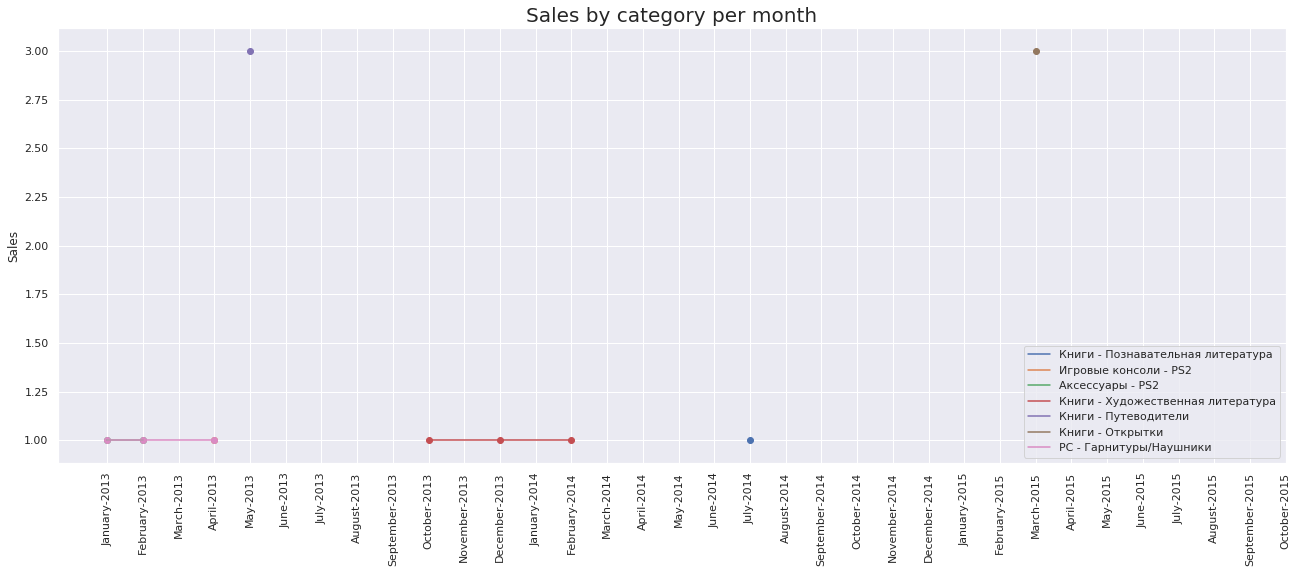

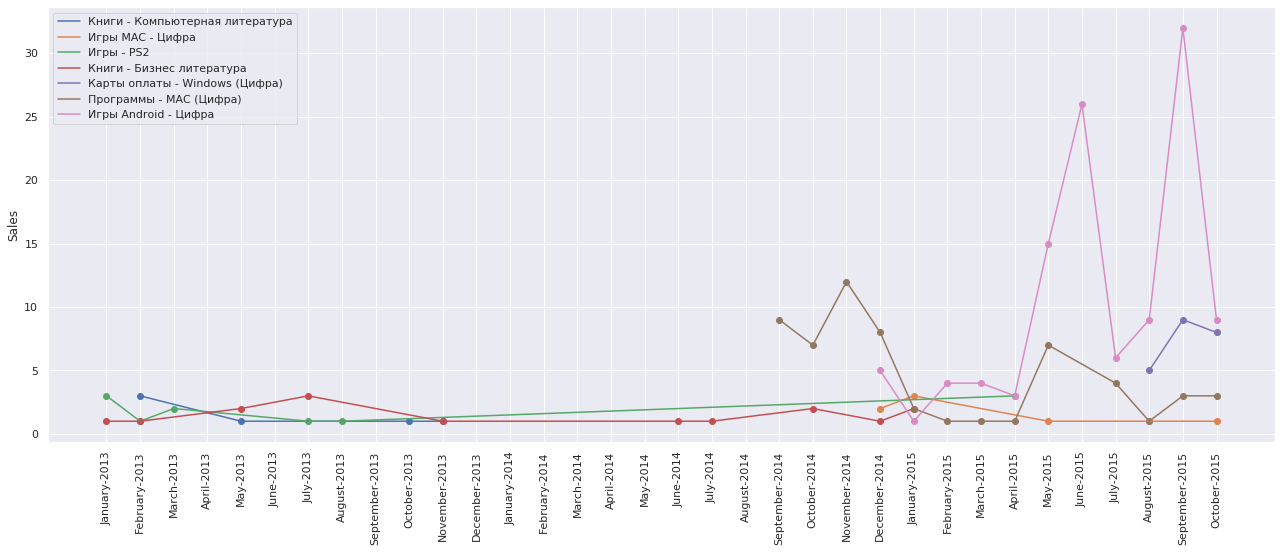

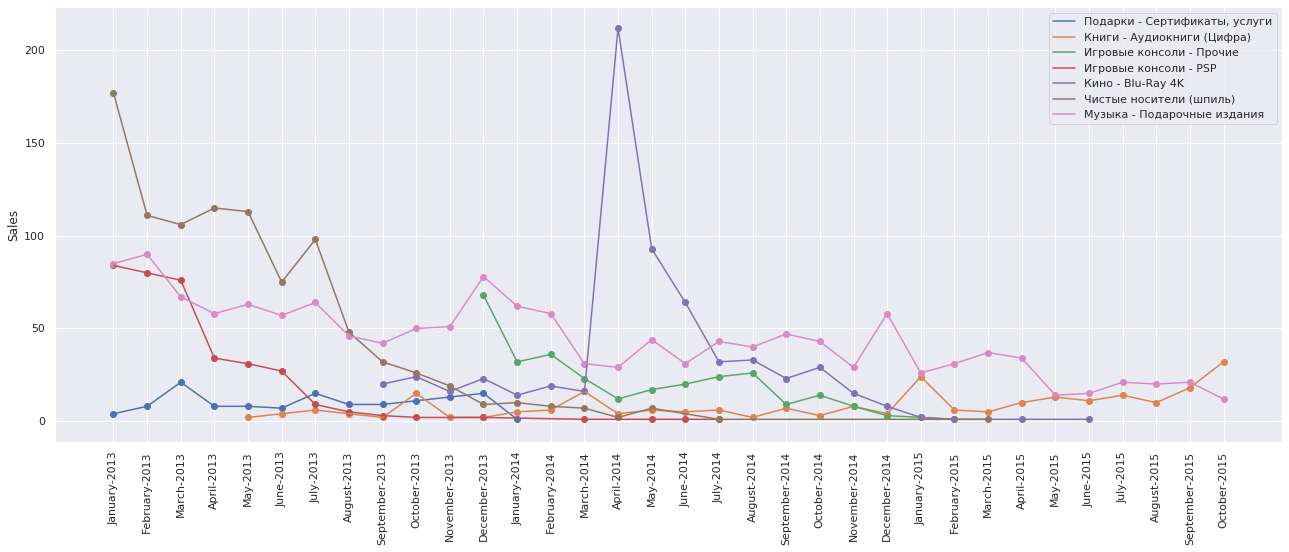

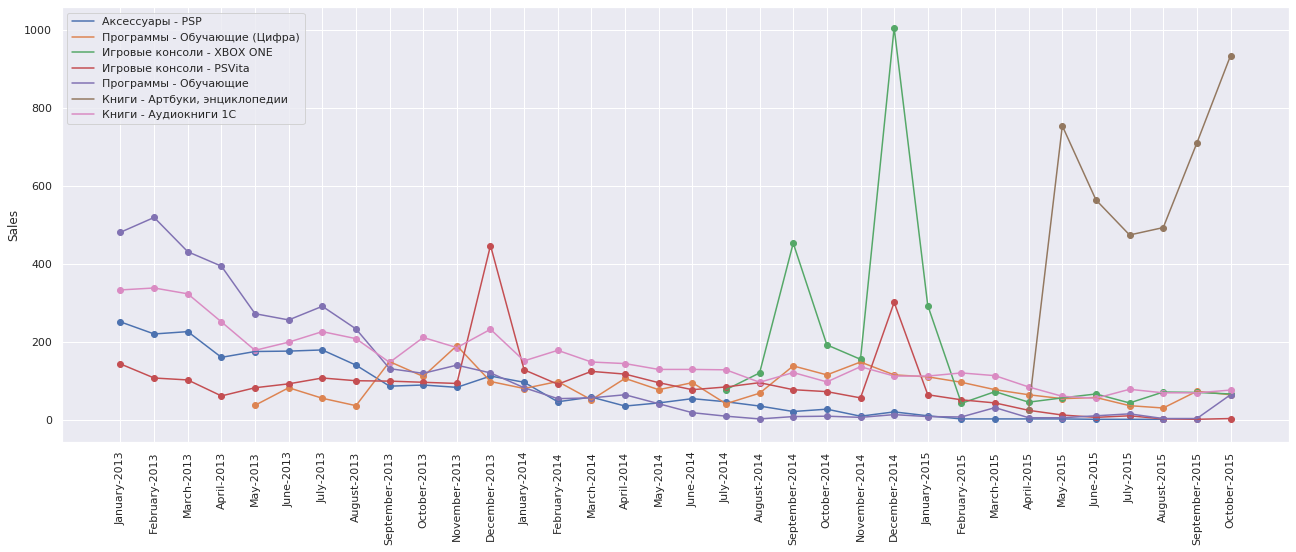

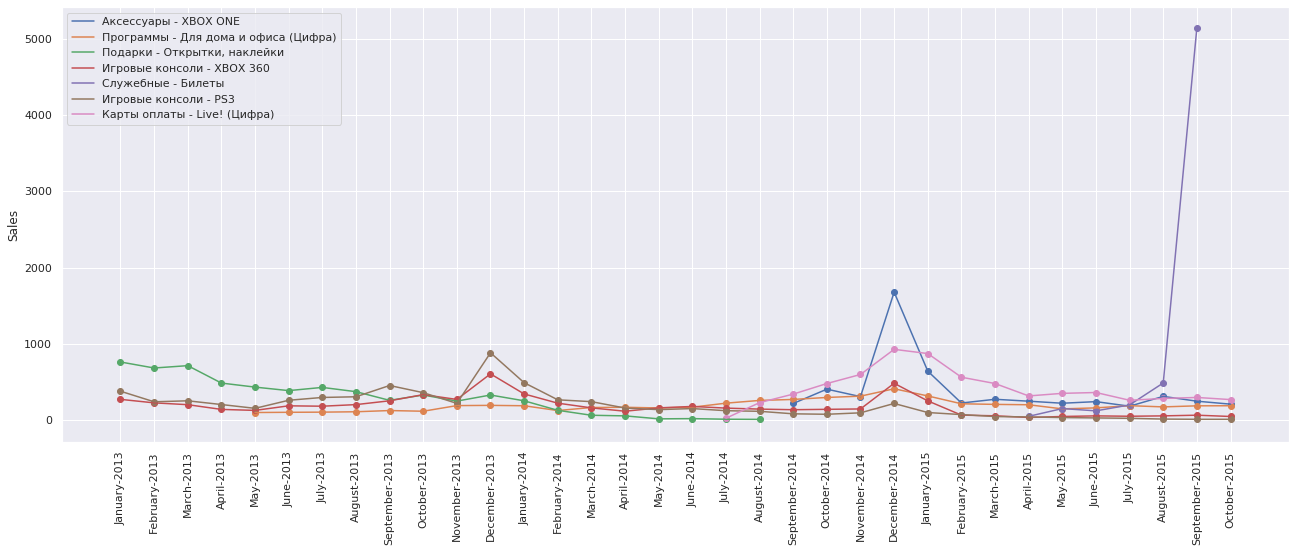

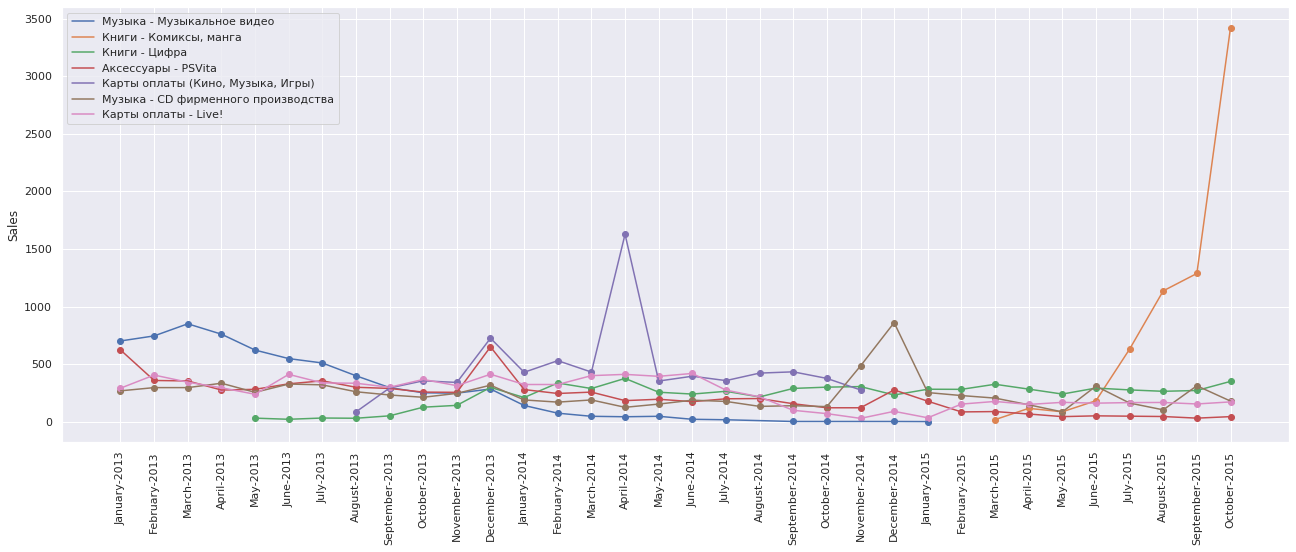

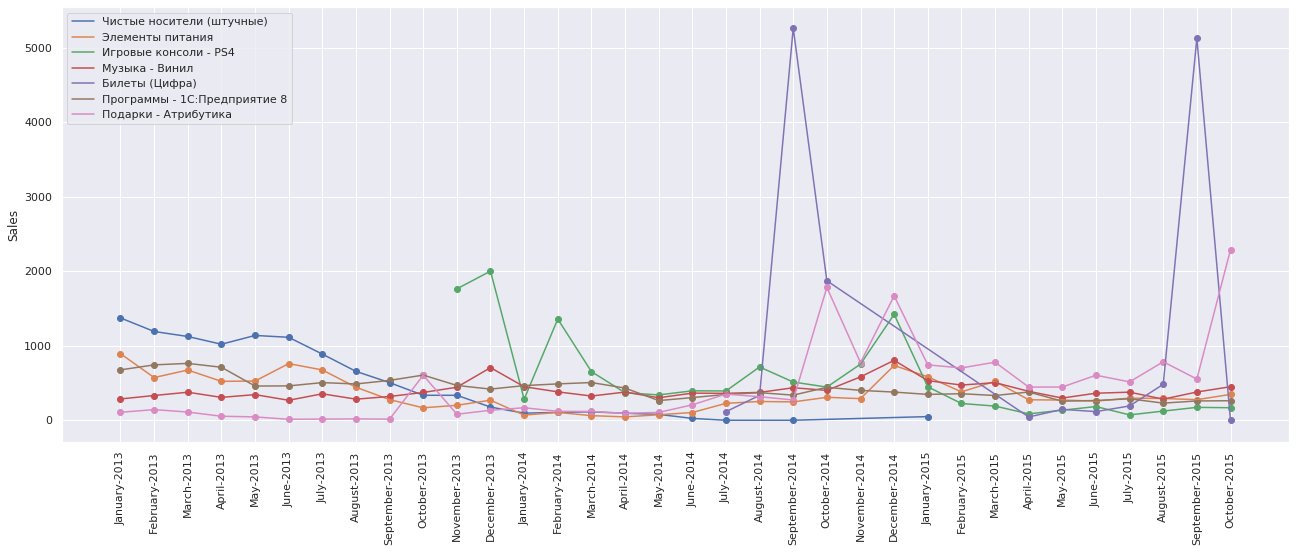

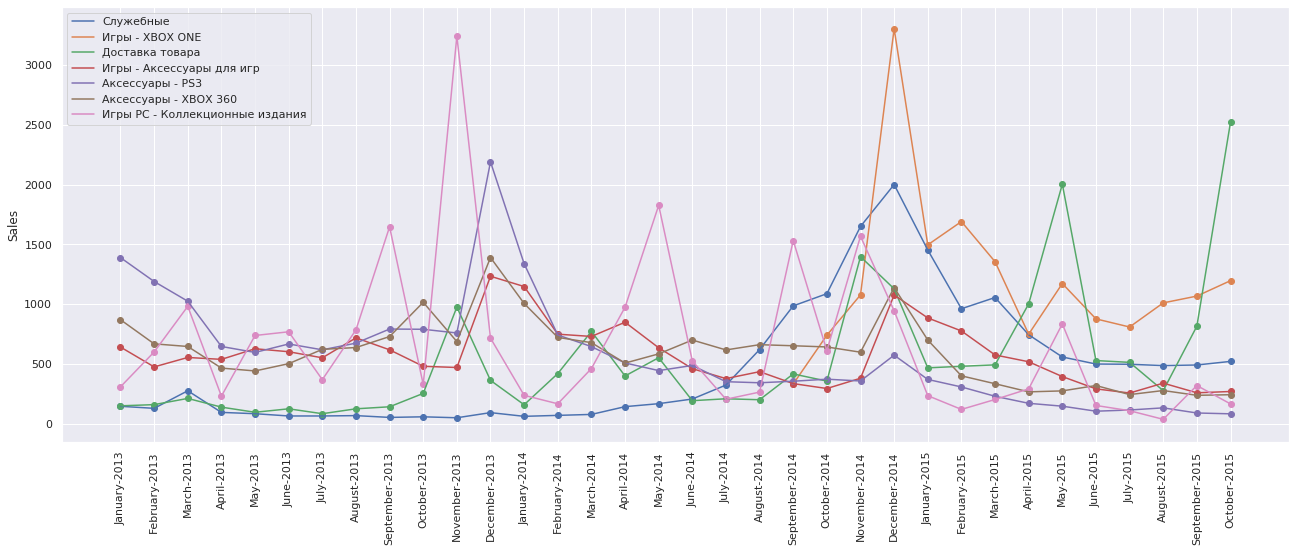

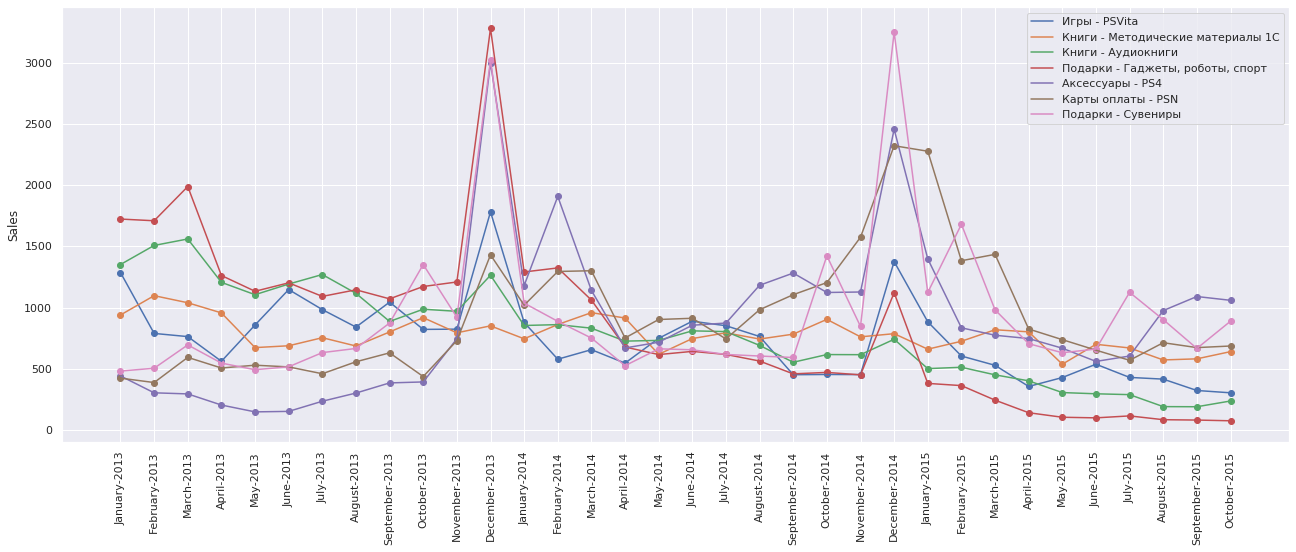

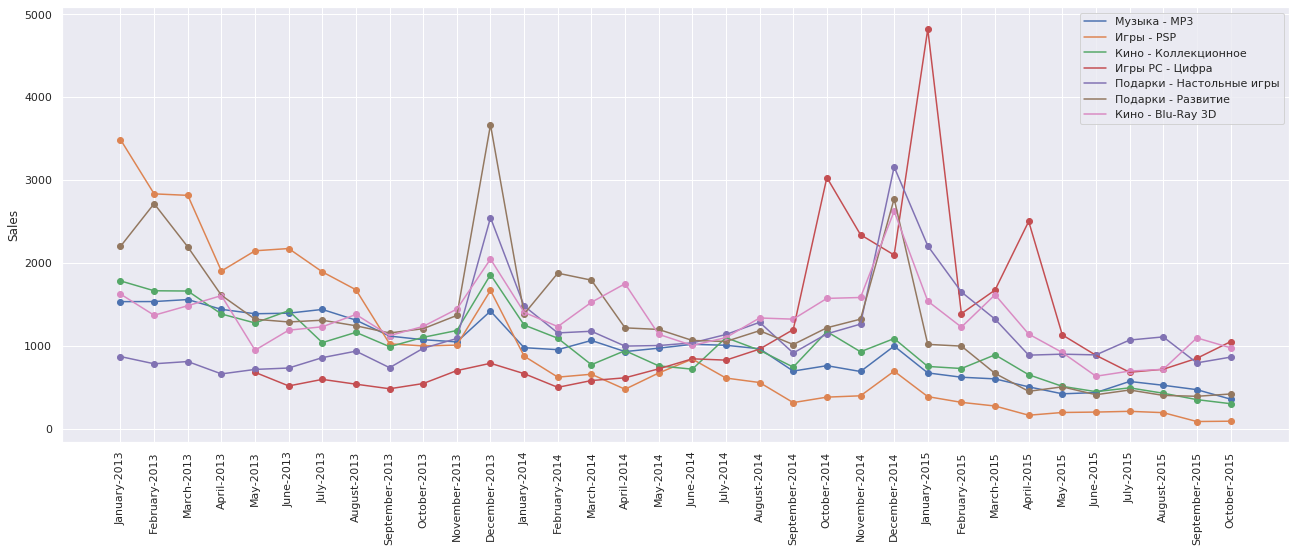

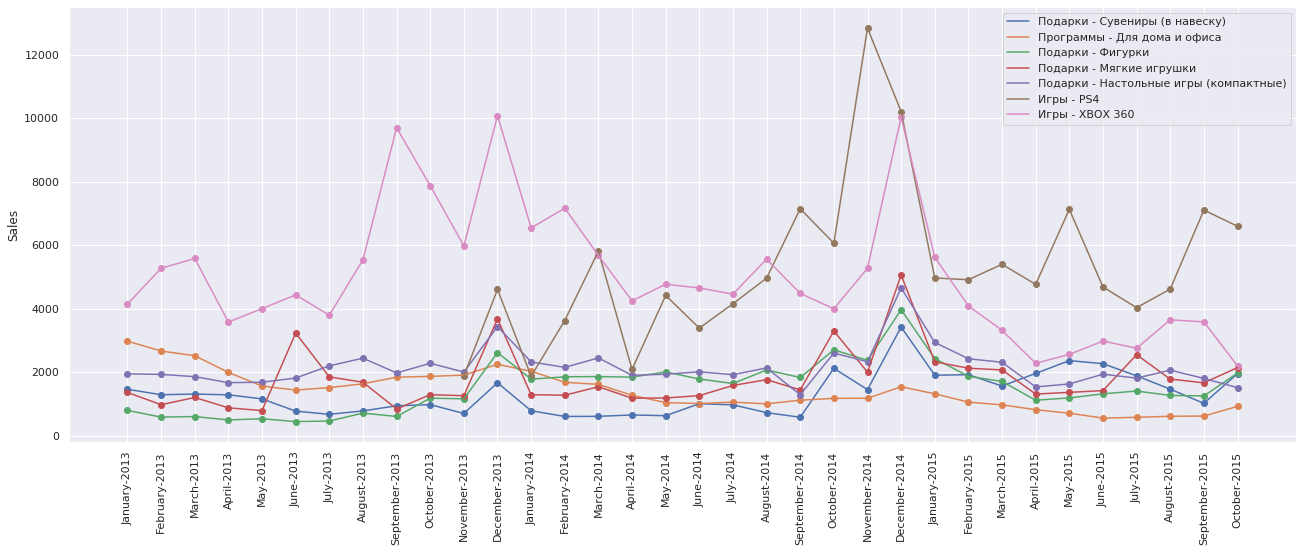

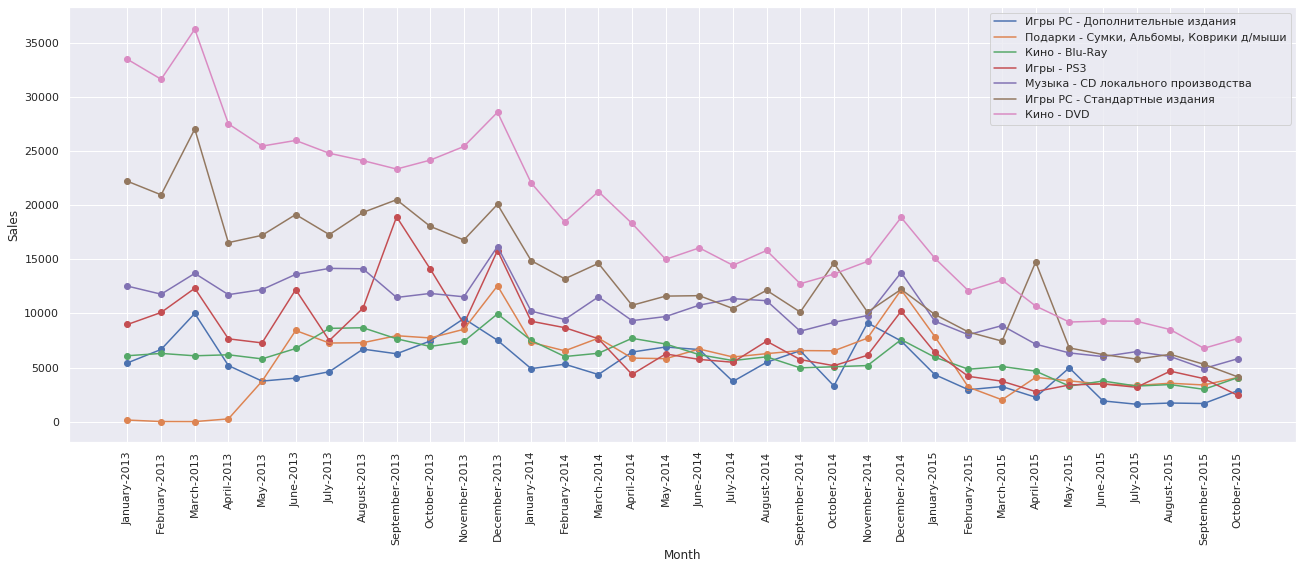

In [24]:
plt.figure(figsize=(22,8))
plt.title('Sales by category per month',fontsize=20)
max_category = 7
count = 0
for i,item in enumerate(sorted_category.item_category_name.unique()):
    if count == max_category:
        count = 0
        plt.xticks(np.arange(0,34),xlabels, rotation=90)
        plt.legend()   
        plt.figure(figsize=(22,8))
        
    plot_df = cat_by_month[cat_by_month.item_category_name == item].sort_values('date_block_num')
    x = plot_df.date_block_num.values
    y = plot_df.item_cnt_month.values
    
    plt.ylabel('Sales')
    plt.scatter(x,y)
    plt.plot(x,y,label=item)
    count = count + 1

plt.xlabel('Month')
plt.legend()    
plt.xticks(np.arange(0,34),xlabels, rotation=90)
plt.show()

/home/mars/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


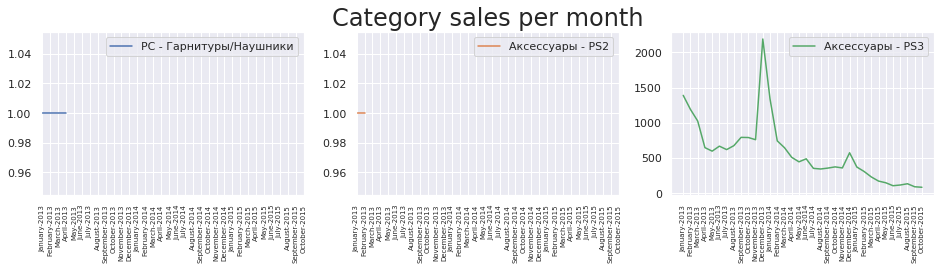

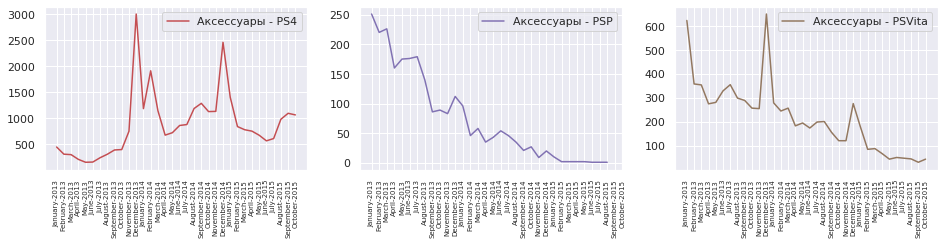

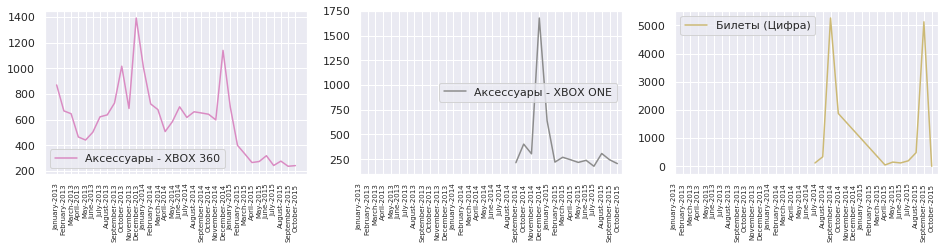

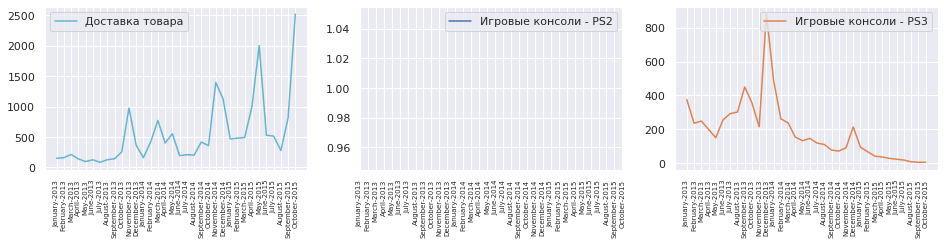

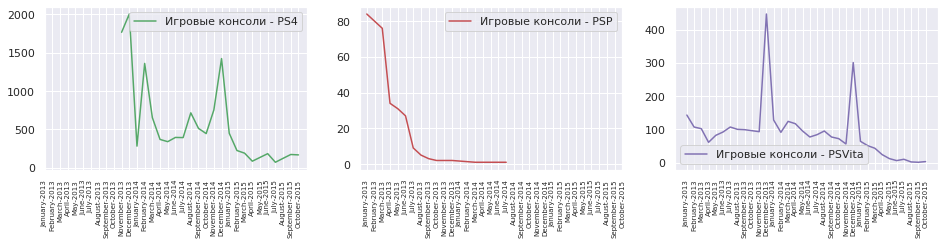

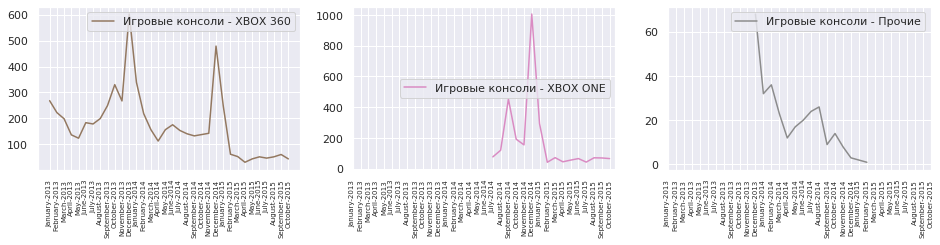

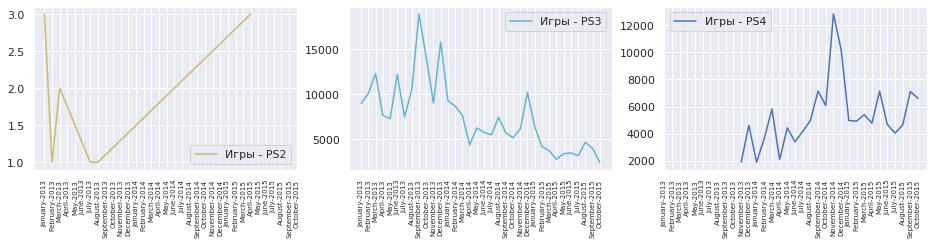

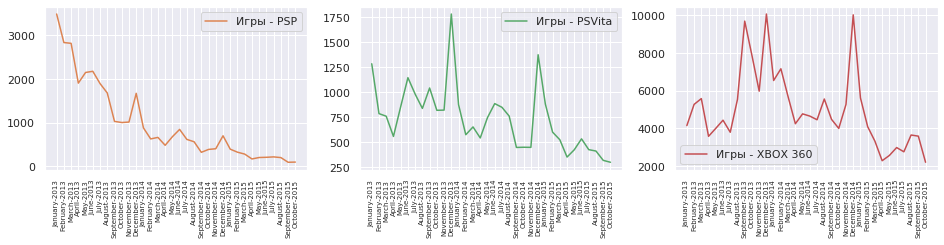

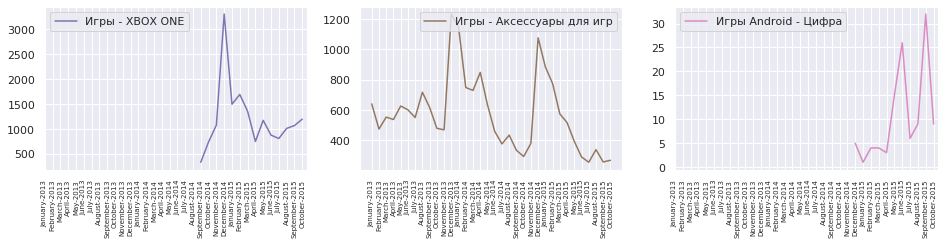

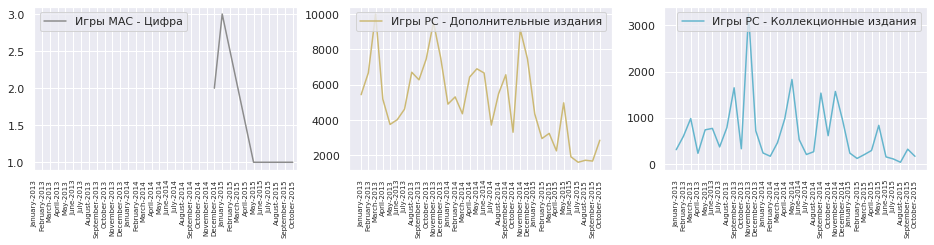

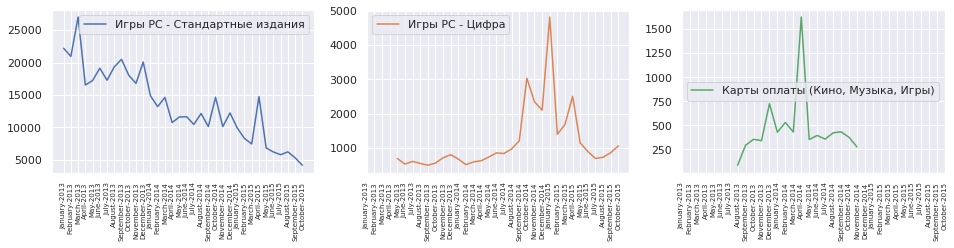

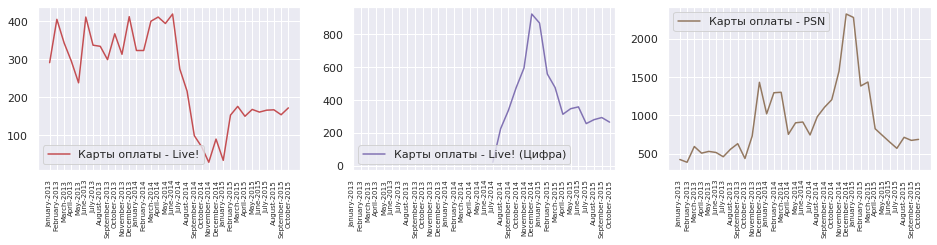

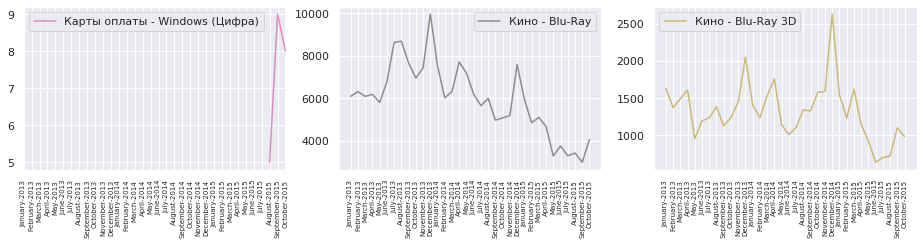

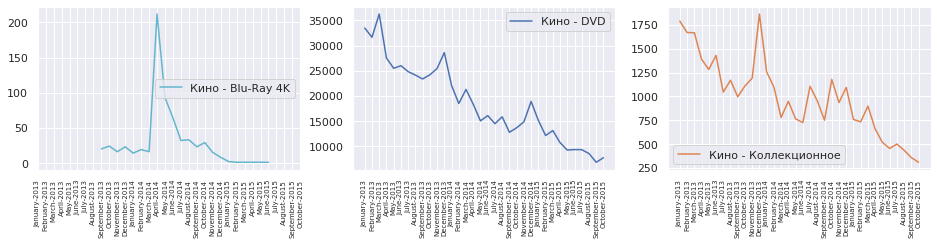

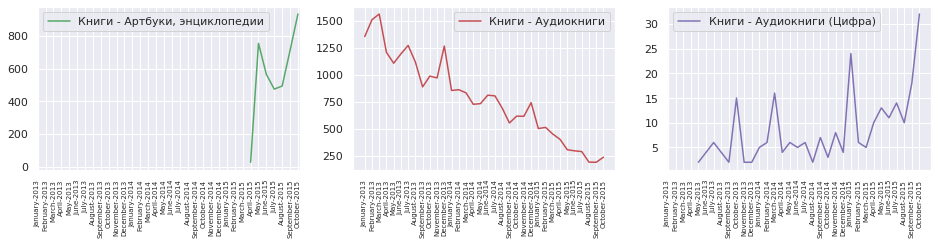

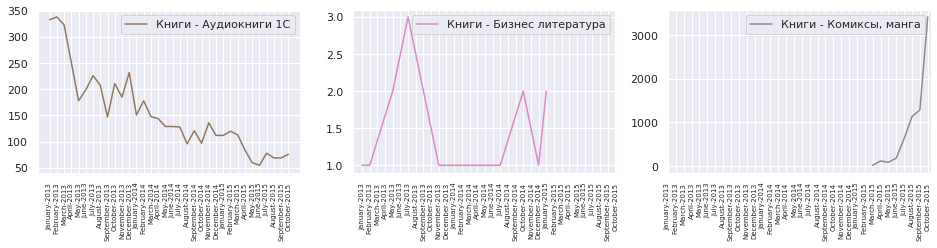

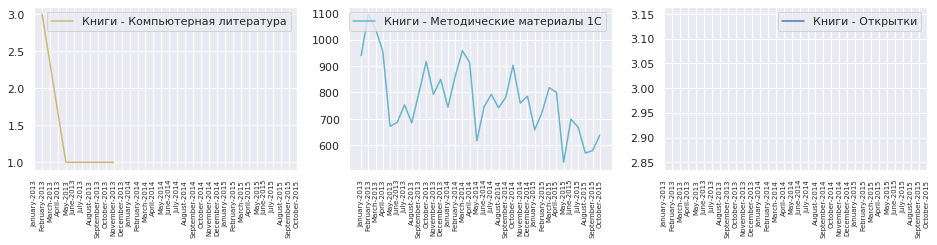

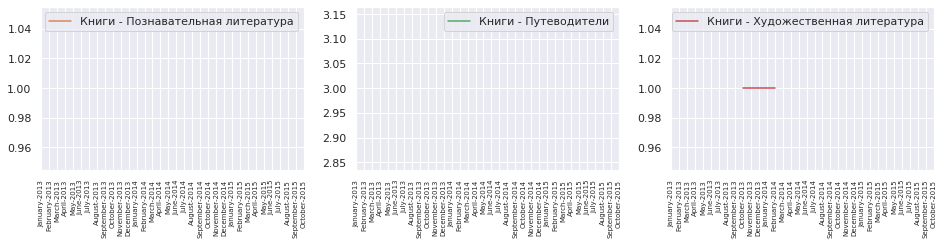

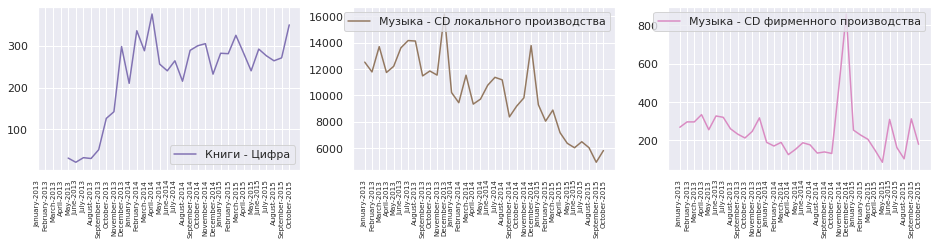

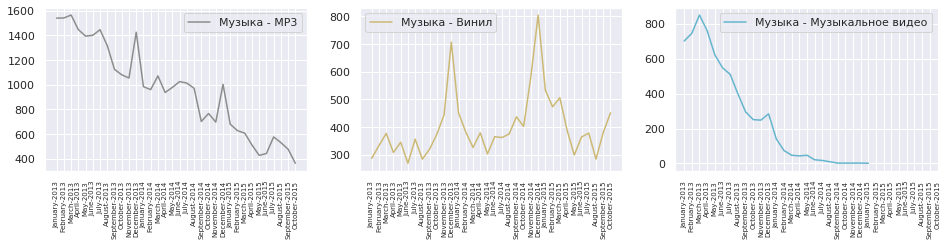

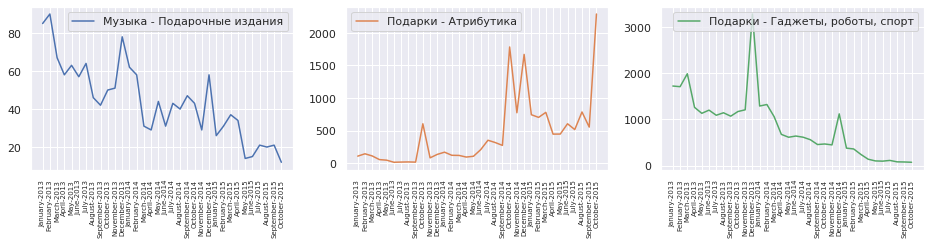

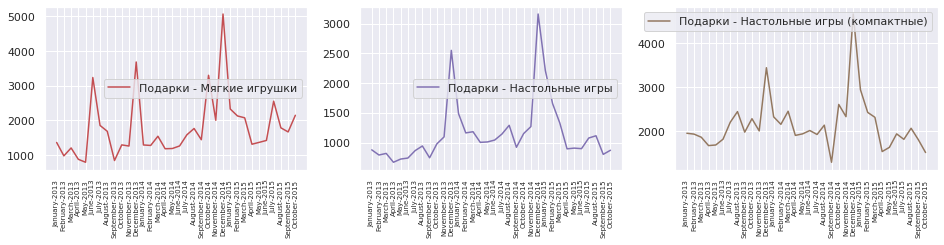

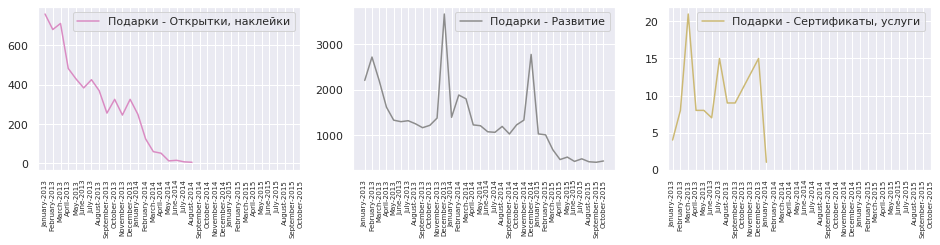

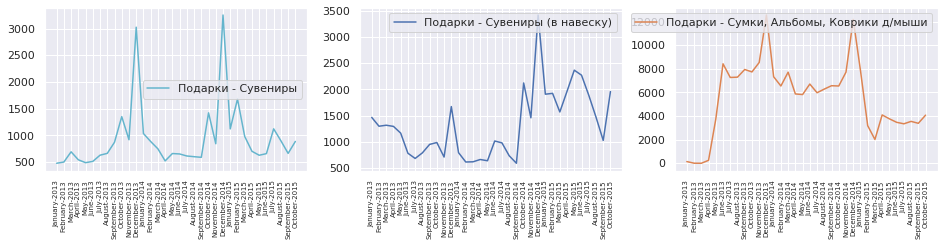

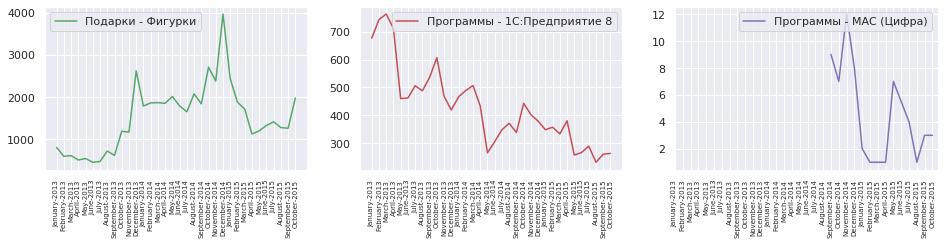

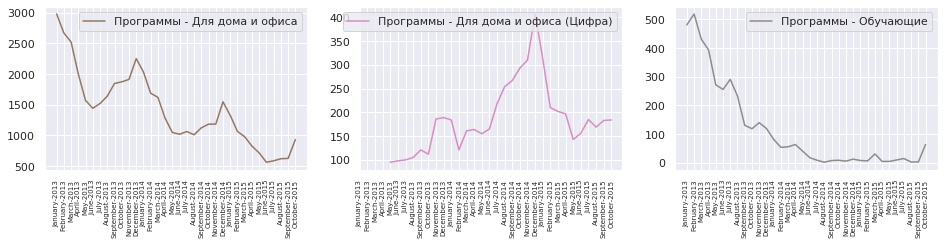

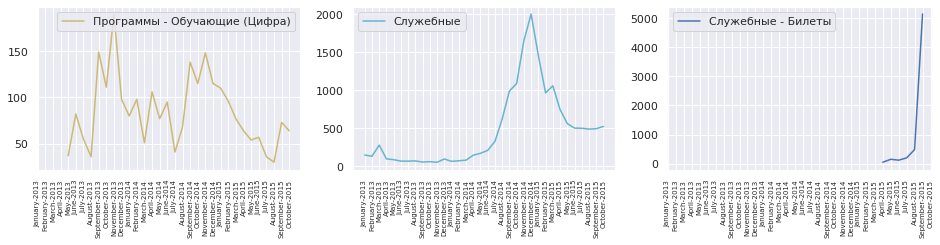

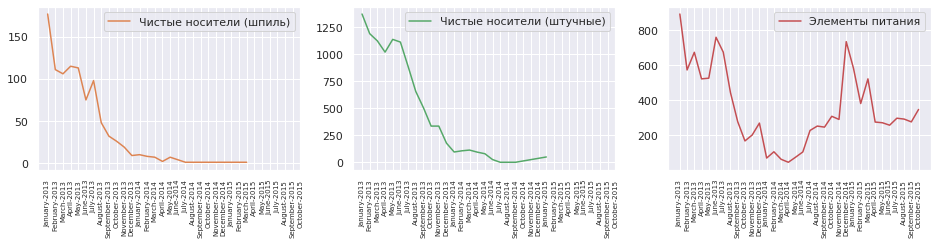

In [25]:
f = plt.figure(figsize=(16,3))
plot_index = 1

plt.subplot(132).set_title('Category sales per month',fontsize=24)
for i,item in enumerate(cat_by_month.item_category_name.unique()):
    if plot_index == 4:
        plot_index = 1   
        plt.show()
        f = plt.figure(figsize=(16,3))
        
    ax = f.add_subplot(1,3,plot_index)
    plot_df = cat_by_month[cat_by_month.item_category_name == item]
    ax.plot(plot_df.date_block_num.values,
             plot_df.item_cnt_month.values,
             label=item,
             color='C'+str(i))
    ax.set_xticks(np.arange(0,34))
    ax.set_xticklabels(xlabels, fontsize=7)
    
    ax.legend()
    
    plot_index = plot_index + 1
    plt.setp(ax.get_xticklabels(), rotation=90)
    

plt.show()

In [26]:
#pattern for each shop
shop_by_month = train_df.groupby(['shop_name','date_block_num'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")

In [27]:
sorted_shop = shop_by_month.groupby(['shop_name'])['item_cnt_month'].sum().sort_values().reset_index(name="item_cnt_total")

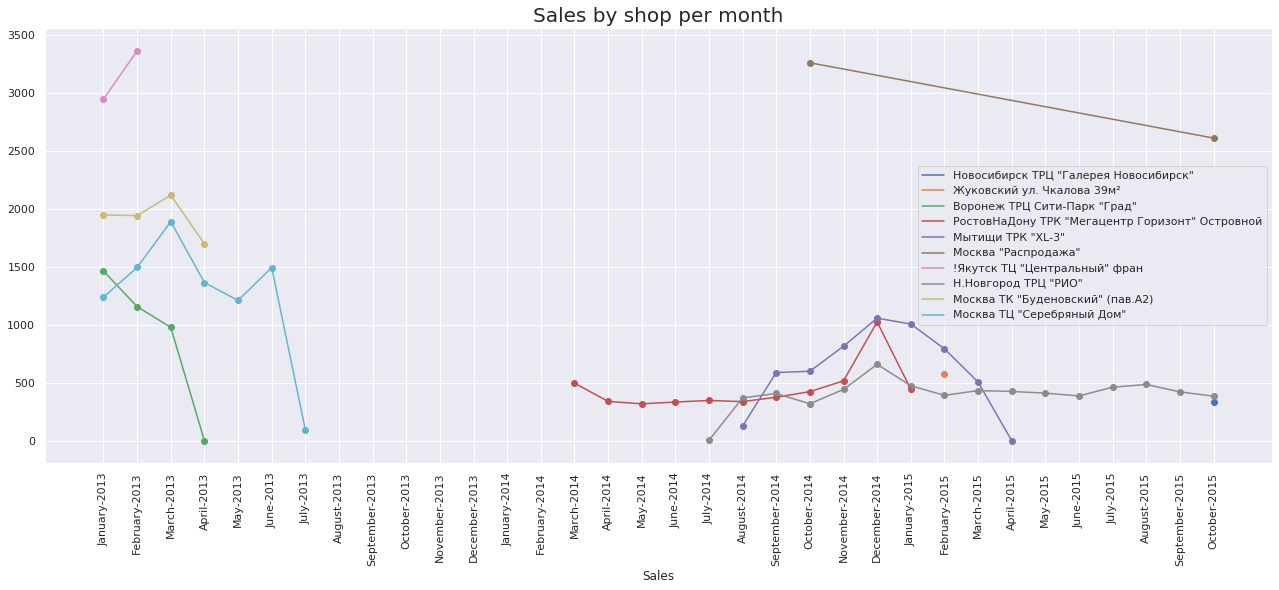

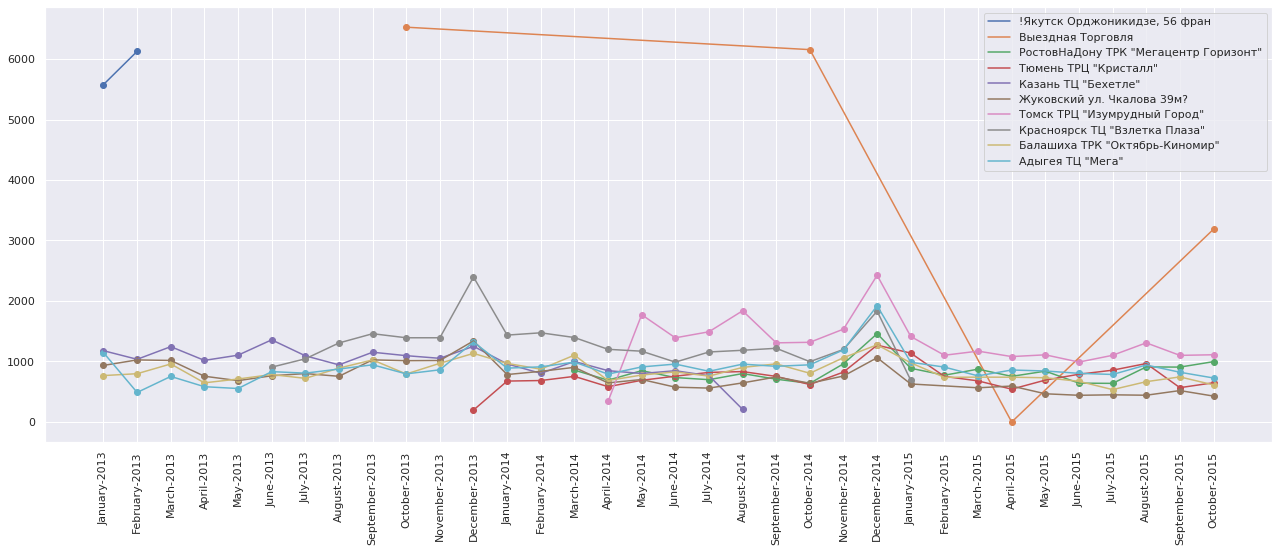

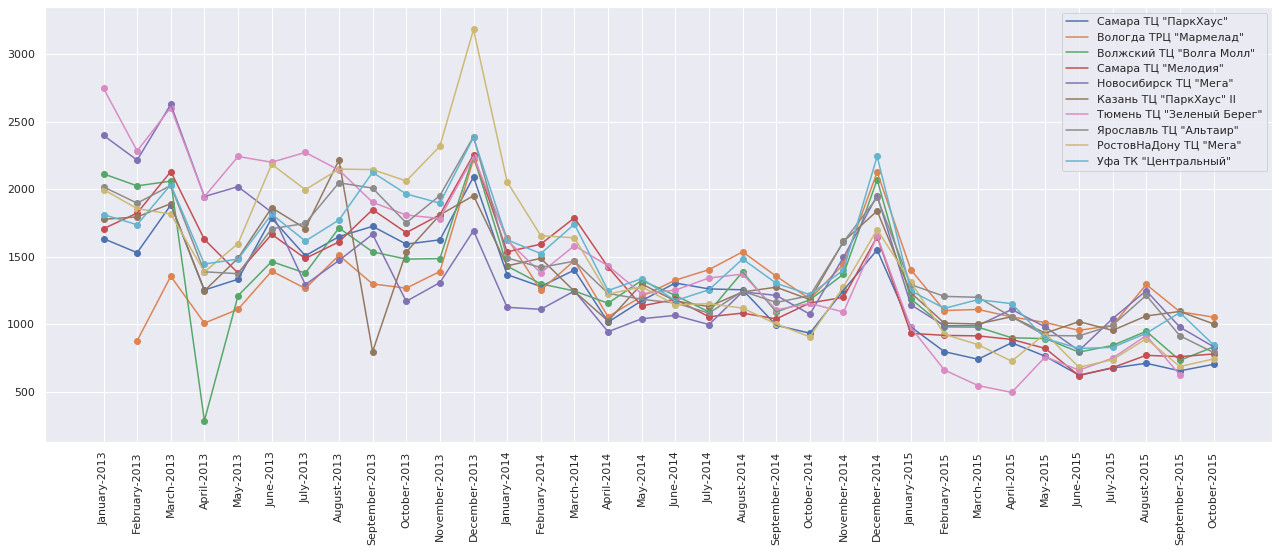

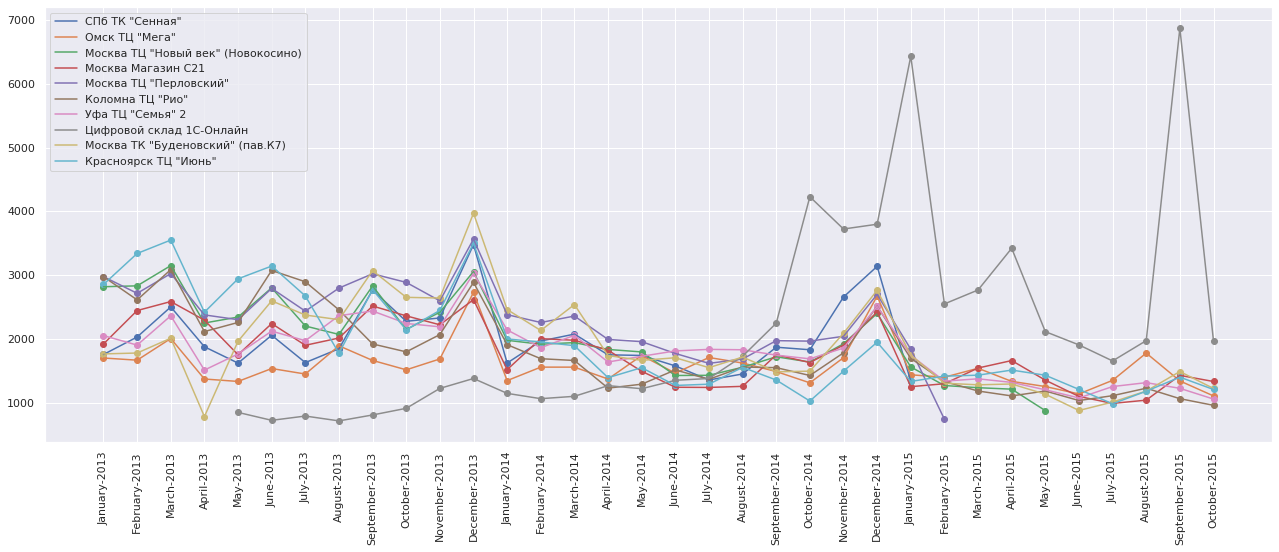

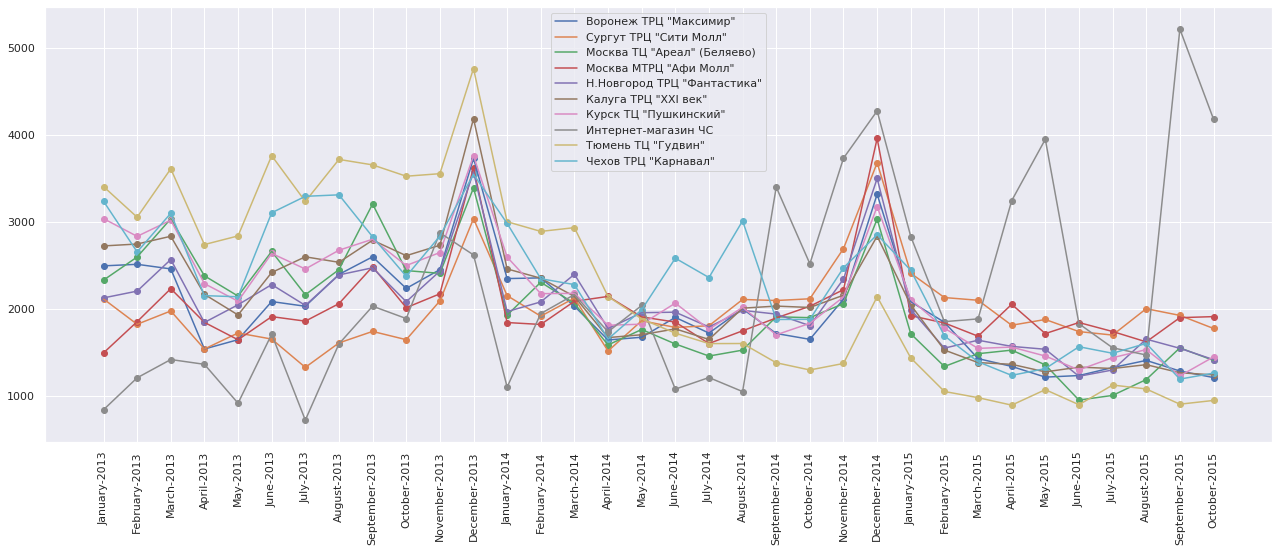

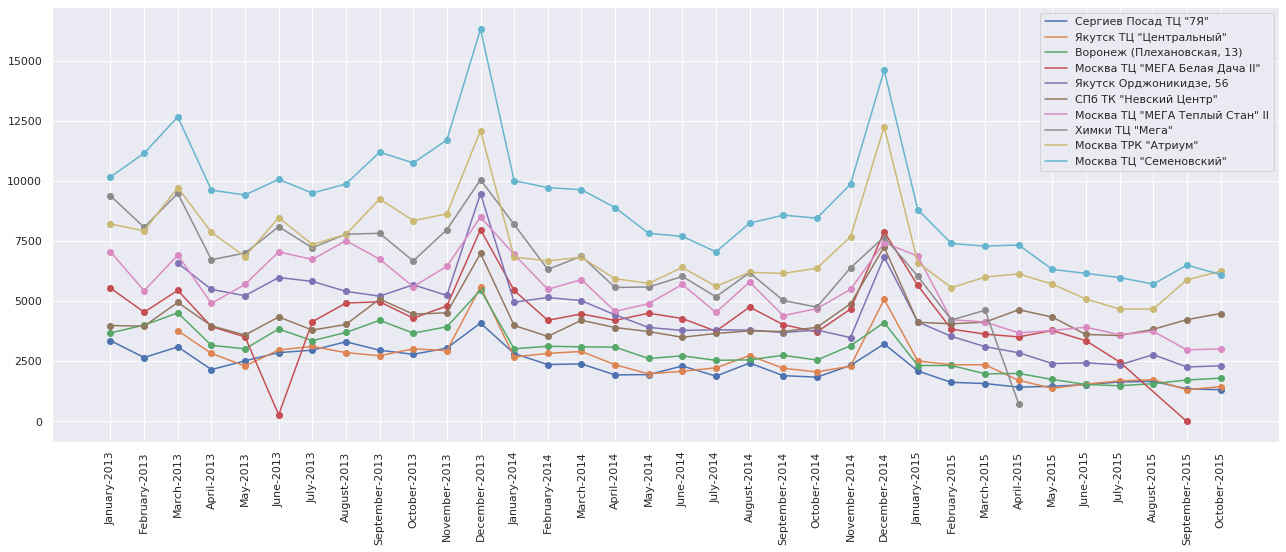

In [28]:
plt.figure(figsize=(22,8))
plt.title('Sales by shop per month',fontsize=20)
plt.xlabel('Month')
plt.xlabel('Sales')

max_shop = 10
count = 0
for i,item in enumerate(sorted_shop.shop_name.unique()):
    if count == max_shop:
        plt.xticks(np.arange(0,34),xlabels, rotation=90)
        plt.legend()
        plt.show()
        plt.figure(figsize=(22,8))
        count = 0
    plot_df = shop_by_month[shop_by_month.shop_name == item]
    x = plot_df.date_block_num.values
    y= plot_df.item_cnt_month.values
    plt.scatter(x,
             y)
    plt.plot(x,
             y,
             label=item)
    count = count + 1

plt.xticks(np.arange(0,34),xlabels, rotation=90)
plt.legend()    
plt.show()

/home/mars/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


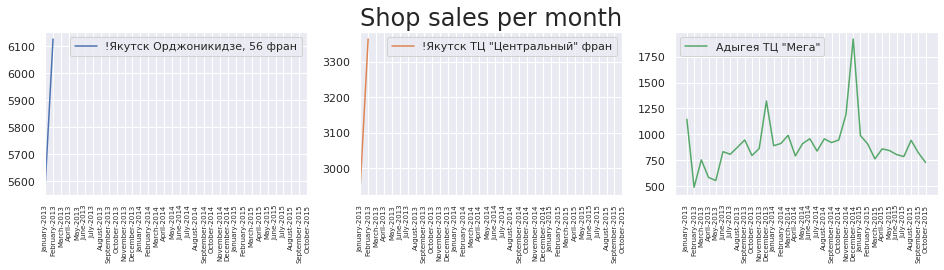

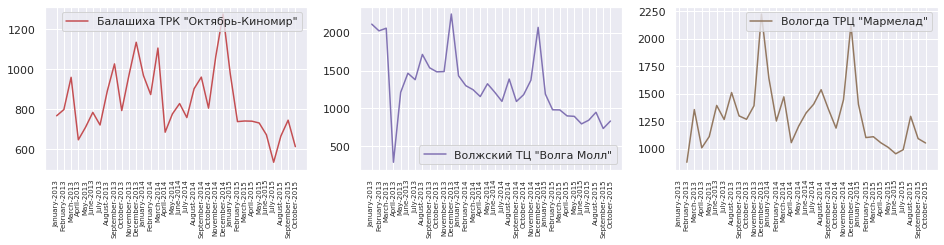

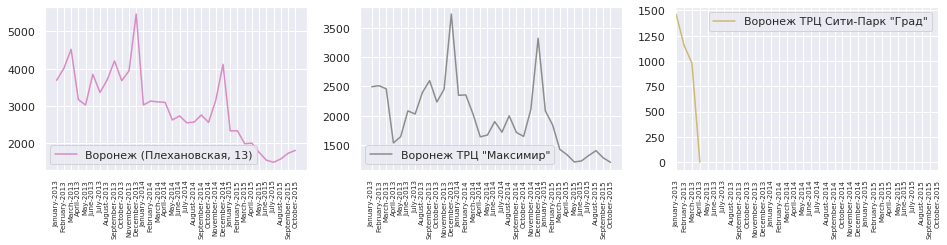

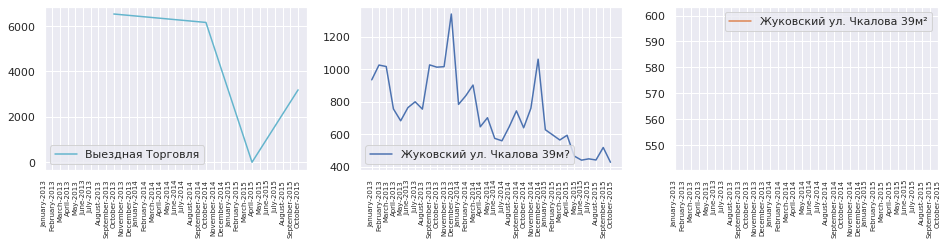

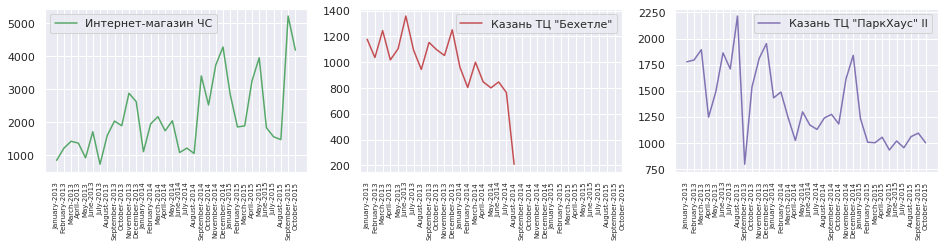

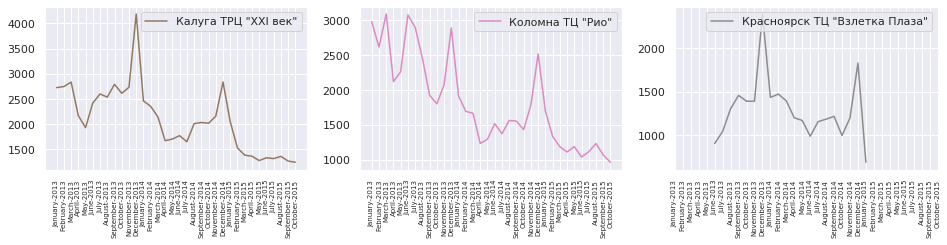

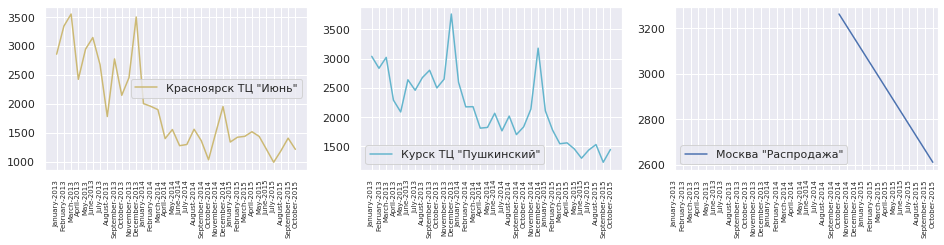

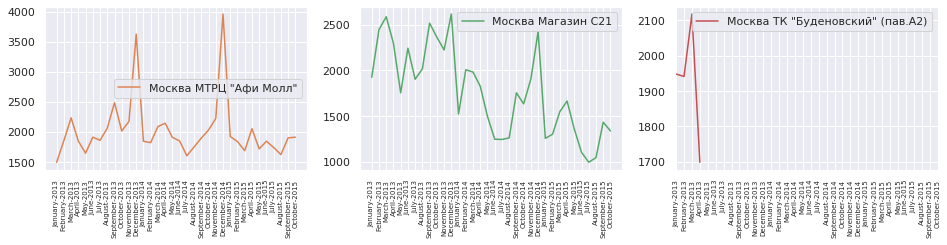

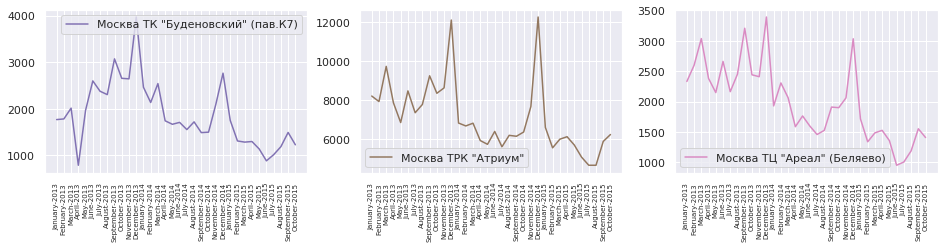

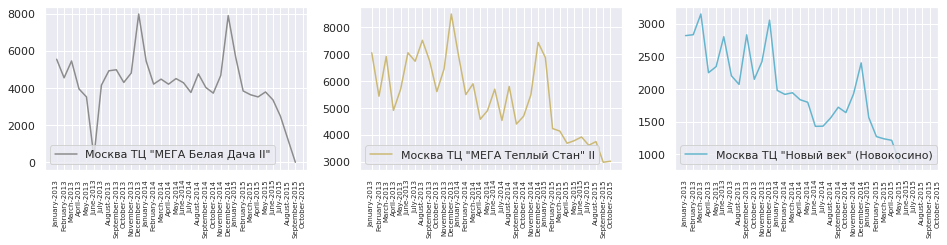

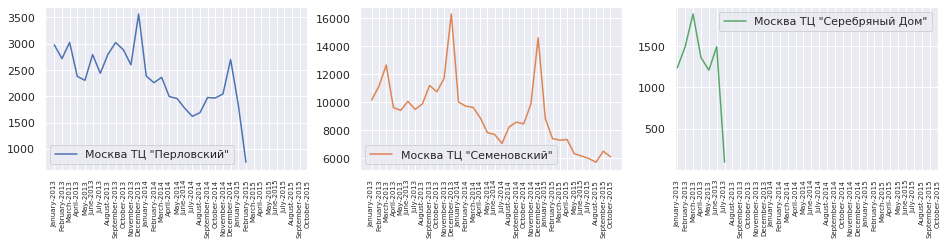

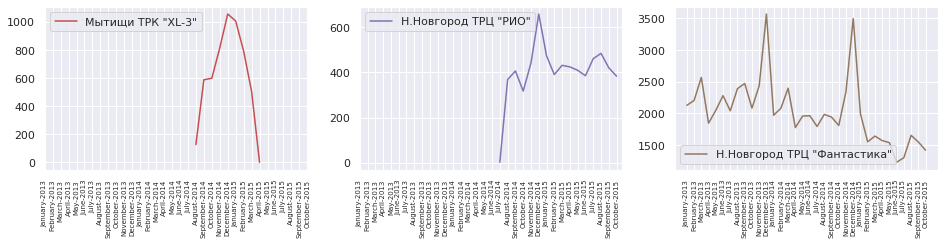

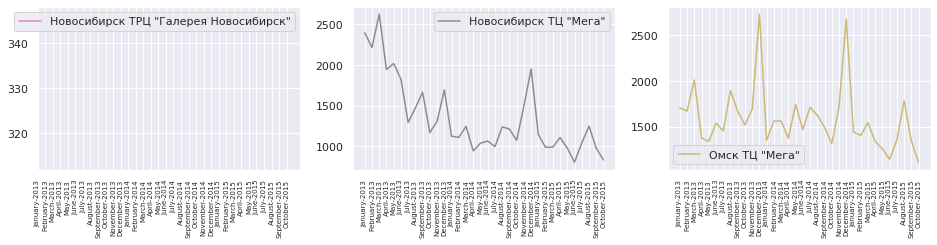

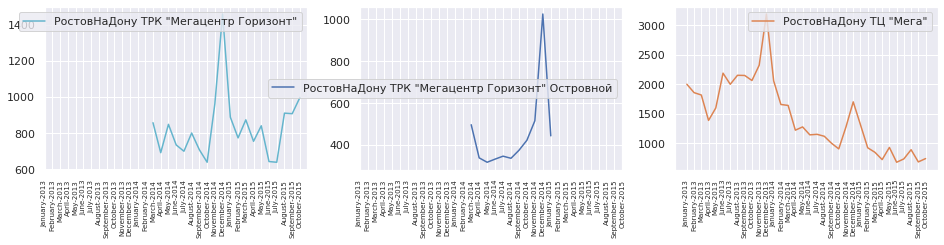

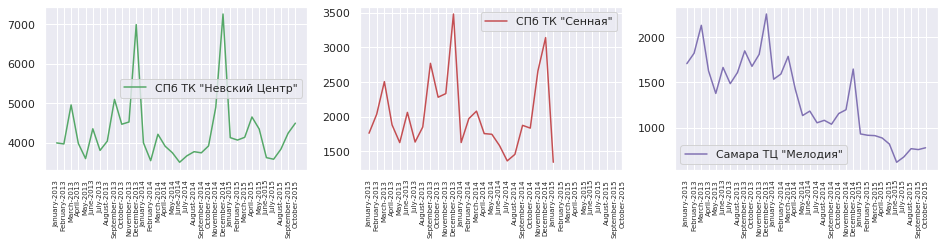

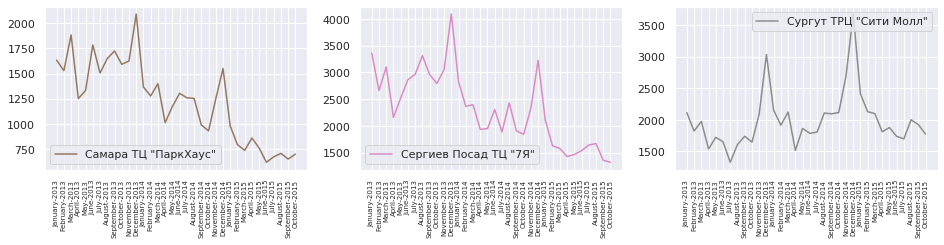

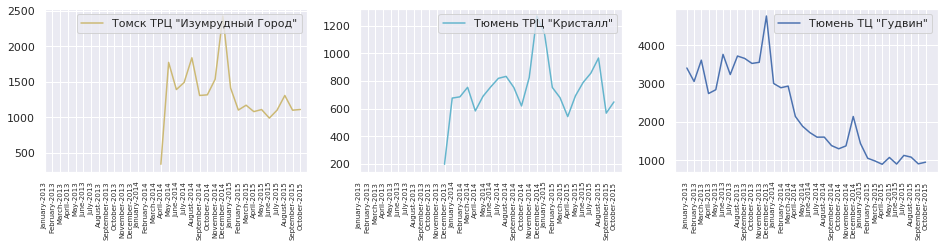

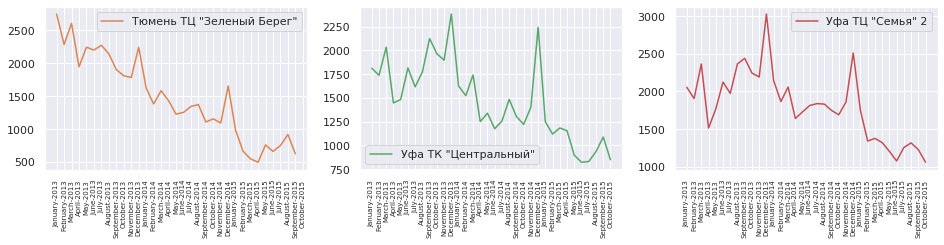

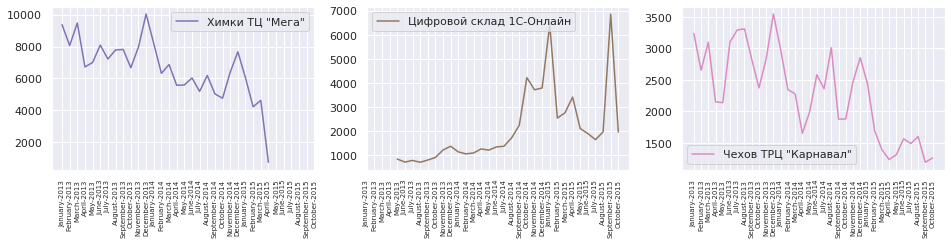

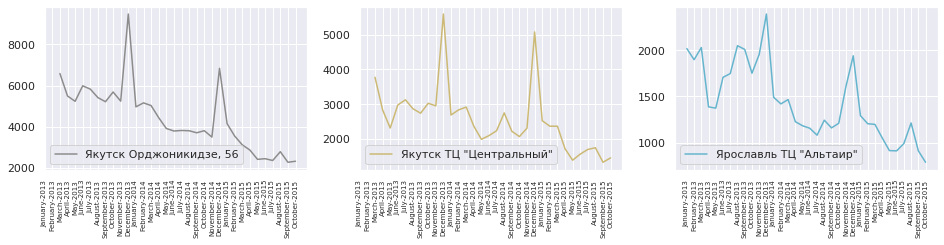

In [29]:
#Deeper view

f = plt.figure(figsize=(16,3))
plot_index = 1

plt.subplot(132).set_title('Shop sales per month',fontsize=24)
for i,item in enumerate(shop_by_month.shop_name.unique()):
    if plot_index == 4:
        plot_index = 1   
        plt.show()
        f = plt.figure(figsize=(16,3))
        
    ax = f.add_subplot(1,3,plot_index)
    plot_df = shop_by_month[shop_by_month.shop_name == item]
    ax.plot(plot_df.date_block_num.values,
             plot_df.item_cnt_month.values,
             label=item,
             color='C'+str(i))
    ax.set_xticks(np.arange(0,34))
    ax.set_xticklabels(xlabels, fontsize=7)
    
    ax.legend()
    
    plot_index = plot_index + 1
    plt.setp(ax.get_xticklabels(), rotation=90)
    

plt.show()

## Data Engineering

Now, we will prepare the data to be in a form where it can fit into a model.

based on competition description

"We are asking you to predict total sales for every product and store in the **next month**. By solving this competition you will be able to apply and enhance your data science skills."

So, since we are predicting the next month we should shift the target for each instances

In [30]:
#preparing data for modelling
train_df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_name', 'item_category_id',
       'item_category_name', 'category_rank', 'shop_rank', 'month_year'],
      dtype='object')

In [31]:
aggregated_train = train_df.groupby(['date_block_num','shop_id','item_id'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")
aggregated_train['target'] = aggregated_train['item_cnt_month'].shift(1)
aggregated_train.head()

date_block_num  shop_id  item_id  item_cnt_month  target
0               0        0       32             6.0     NaN
1               0        0       33             3.0     6.0
2               0        0       35             1.0     3.0
3               0        0       43             1.0     1.0
4               0        0       51             2.0     1.0

You can shift how many month you like depends on how far you want to predict, however if you want to predict for all months in between, that requires more work.

Now, we going to create time lag. time lag is basically just how far are we going to look back in the time series for learning.

In [32]:
TIME_LAG = 5

for i in range(1,TIME_LAG+1):
    aggregated_train['time_lag_'+str(i)] = aggregated_train['item_cnt_month'].shift(-i)

aggregated_train.head()

date_block_num  shop_id  item_id  item_cnt_month  target  time_lag_1  \
0               0        0       32             6.0     NaN         3.0   
1               0        0       33             3.0     6.0         1.0   
2               0        0       35             1.0     3.0         1.0   
3               0        0       43             1.0     1.0         2.0   
4               0        0       51             2.0     1.0         1.0   

   time_lag_2  time_lag_3  time_lag_4  time_lag_5  
0         1.0         1.0         2.0         1.0  
1         1.0         2.0         1.0         1.0  
2         2.0         1.0         1.0         1.0  
3         1.0         1.0         1.0         1.0  
4         1.0         1.0         1.0         1.0

In [33]:
useless_features = ['date', 'date_block_num',
                    'item_cnt_day', 'shop_name', 'item_name', 'item_category_id', 
                    'item_category_name', 'month_year']

In [34]:
scaler = MinMaxScaler()

selected_train_df = train_df.drop(columns=useless_features)
selected_train_df[['shop_rank','category_rank','item_price']] = scaler.fit_transform(selected_train_df[['shop_rank','category_rank','item_price']])
selected_train_df

shop_id  item_id  item_price  category_rank  shop_rank
0             59    22154    0.003247       0.967742   0.508475
1             25     2552    0.002922       0.935484   0.983051
2             25     2552    0.002922       0.935484   0.983051
3             25     2554    0.005552       0.935484   0.983051
4             25     2555    0.003572       0.806452   0.983051
...          ...      ...         ...            ...        ...
2935844       25     7409    0.000974       0.983871   0.983051
2935845       25     7460    0.000974       0.983871   0.983051
2935846       25     7459    0.001136       0.983871   0.983051
2935847       25     7440    0.000974       0.822581   0.983051
2935848       25     7460    0.000974       0.983871   0.983051

[2935849 rows x 5 columns]

From the engineered features that we created, we need some sort of encoder that can be use for both training and test data.

In [35]:
#Test variable
shop_id = 59
item_id = 22154

In [36]:
print(f" Total unique shop {train_df.shop_id.nunique()} ")
print(f" Total unique item {train_df.item_id.nunique()} ")

 Total unique shop 60 
 Total unique item 21807 


In [37]:
shop_encoder = selected_train_df[['shop_id','shop_rank']].sort_values('shop_id').drop_duplicates().values
shop_encoder = dict(shop_encoder)
print(f"Shop rank for shop with id 25 is {shop_encoder[25]}") #check with data frame

category_encoder = selected_train_df[['item_id','category_rank']].sort_values('item_id').drop_duplicates().values
category_encoder = dict(category_encoder)
print(f"Item rank for item with id 22154 is {category_encoder[22154]}")

price_encoder = selected_train_df[['item_id','item_price']].sort_values('item_id').drop_duplicates().values
price_encoder = dict(price_encoder)
print(f"Price for item with id 22154 is {price_encoder[2554]}")

Shop rank for shop with id 25 is 0.9830508474576272
Item rank for item with id 22154 is 0.967741935483871
Price for item with id 22154 is 0.0055524529110562


A simple dictionary approach for encoding

In [38]:
aggregated_train['shop_rank'] = aggregated_train['shop_id'] .map(shop_encoder)
aggregated_train['category_rank'] = aggregated_train['item_id'] .map(category_encoder)
aggregated_train['price'] = aggregated_train['item_id'] .map(price_encoder)

In [39]:
aggregated_train.head()

date_block_num  shop_id  item_id  item_cnt_month  target  time_lag_1  \
0               0        0       32             6.0     NaN         3.0   
1               0        0       33             3.0     6.0         1.0   
2               0        0       35             1.0     3.0         1.0   
3               0        0       43             1.0     1.0         2.0   
4               0        0       51             2.0     1.0         1.0   

   time_lag_2  time_lag_3  time_lag_4  time_lag_5  shop_rank  category_rank  \
0         1.0         1.0         2.0         1.0   0.186441       1.000000   
1         1.0         2.0         1.0         1.0   0.186441       0.967742   
2         2.0         1.0         1.0         1.0   0.186441       1.000000   
3         1.0         1.0         1.0         1.0   0.186441       1.000000   
4         1.0         1.0         1.0         1.0   0.186441       0.822581   

      price  
0  0.001135  
1  0.000420  
2  0.000484  
3  0.000484  
4  0.000649

In [40]:
# aggregated_train.groupby(['shop_id','item_id'])['date_block_num'].max().reset_index()
time_lag_df = aggregated_train.dropna()\
            .sort_values(by=['date_block_num'], 
                         ascending=False)\
            .drop_duplicates(subset=['shop_id','item_id'],
                             keep='first')\
            .drop(columns=['date_block_num','shop_rank','category_rank','price','item_cnt_month','target'])
time_lag_df

shop_id  item_id  time_lag_1  time_lag_2  time_lag_3  time_lag_4  \
1609118       59    21812         6.0         2.0         1.0         1.0   
1588091       24     8736         2.0         2.0         1.0         1.0   
1588093       24     8738         1.0         1.0         3.0         1.0   
1588094       24     8743         1.0         3.0         1.0         1.0   
1588095       24     9337         3.0         1.0         1.0         1.0   
...          ...      ...         ...         ...         ...         ...   
42157         37    19078         1.0         1.0         1.0         1.0   
42152         37    18928         4.0         4.0         1.0         1.0   
42149         37    18860         1.0         1.0         1.0         4.0   
42148         37    18857         1.0         1.0         1.0         1.0   
42143         37    18797         1.0         2.0         1.0         4.0   

         time_lag_5  
1609118         1.0  
1588091         3.0  
1588093         1.0  
1588094         1.0  
1588095         1.0  
...             ...  
42157           1.0  
42152           1.0  
42149           4.0  
42148           4.0  
42143           1.0  

[424124 rows x 7 columns]

In [78]:
time_lag_encoder = np.empty((time_lag_df.shop_id.max()+1,time_lag_df.item_id.max()+1), dtype=list)
for k,v in time_lag_df.iterrows():
    time_lag_encoder[int(v['shop_id'])][int(v['item_id'])] = v.values[2:]
time_lag_encoder

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., array([1., 1., 1., 1., 1.]),
        array([3., 5., 1., 1., 1.]), None],
       ...,
       [None, None, None, ..., array([2., 2., 1., 2., 3.]), None, None],
       [None, None, None, ..., array([1., 1., 2., 1., 1.]), None, None],
       [None, None, None, ..., array([1., 1., 1., 1., 1.]), None, None]],
      dtype=object)

Now we remove unnecessary features

In [42]:
data = aggregated_train.drop(columns=['date_block_num','shop_id','item_cnt_month','item_id']).dropna(how='any')

In [43]:
X = data.drop(columns=['target']).values
Y = data[['target']].values

In [44]:
X[0]

array([1.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.86440678e-01, 9.67741935e-01, 4.19506398e-04])

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=False)

In [46]:
X_train = X_train.reshape(-1,8,1)
X_test = X_test.reshape(-1,8,1)
                        
Y_train = Y_train.reshape(-1,1)                        
Y_test = Y_test.reshape(-1,1)

In [47]:
print(f"X train shape {X_train.shape}")
print(f"X test shape {X_test.shape}")
print()
print(f"Y train shape {Y_train.shape}")
print(f"Y test shape {Y_test.shape}")

X train shape (1287294, 8, 1)
X test shape (321824, 8, 1)

Y train shape (1287294, 1)
Y test shape (321824, 1)


# Modelling

In [56]:
#Settings
BATCH_SIZE = 128
EPOCH = 30

optimizer = Adam(lr=0.001)
#optimizer = RMSProp(lr=0.5)

In [57]:
model3 = Sequential()
model3.add(LSTM(64, input_shape=(X_train.shape[1:])))
model3.add(Dense(1, activation='relu'))

model3.compile(loss='mean_squared_error', optimizer=optimizer)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [58]:
history3 = model3.fit(X_train, Y_train, 
          epochs=EPOCH,
         verbose=1)

Epoch 1/30
1287294/1287294 [==============================] - 198s 154us/step - loss: 67.8140
Epoch 2/30
1287294/1287294 [==============================] - 200s 156us/step - loss: 67.6896
Epoch 3/30
1287294/1287294 [==============================] - 202s 157us/step - loss: 67.5983
Epoch 4/30
1287294/1287294 [==============================] - 202s 157us/step - loss: 67.5201
Epoch 5/30
1287294/1287294 [==============================] - 201s 156us/step - loss: 67.4465
Epoch 6/30
1287294/1287294 [==============================] - 202s 157us/step - loss: 67.4086
Epoch 7/30
1287294/1287294 [==============================] - 202s 157us/step - loss: 67.3502
Epoch 8/30
1287294/1287294 [==============================] - 201s 156us/step - loss: 67.3160
Epoch 9/30
1287294/1287294 [==============================] - 191s 148us/step - loss: 67.2900
Epoch 10/30
1287294/1287294 [==============================] - 186s 144us/step - loss: 67.2355
Epoch 11/30
1287294/1287294 [==============================

The name is model3 is because I did some experiment on 4 different LSTM architecture, here are the key take aways :-  

* Dropout doesn't help in reducing loss, for this data it makes it stuck on local minima on a early epochs

* LSTM Unit, adding more 16 and more than 2 layers makes it suffer to local minima

* Different size of batch been tested (32,64,128,256,512,1024,2056,4112, no batching), the lower the batch size the smoother the learning

* When changing the hyperparameter, initialize back the model. I don't know if its only happen to me, but the model will stuck on the same loss if I didn't re-initialize back the model.

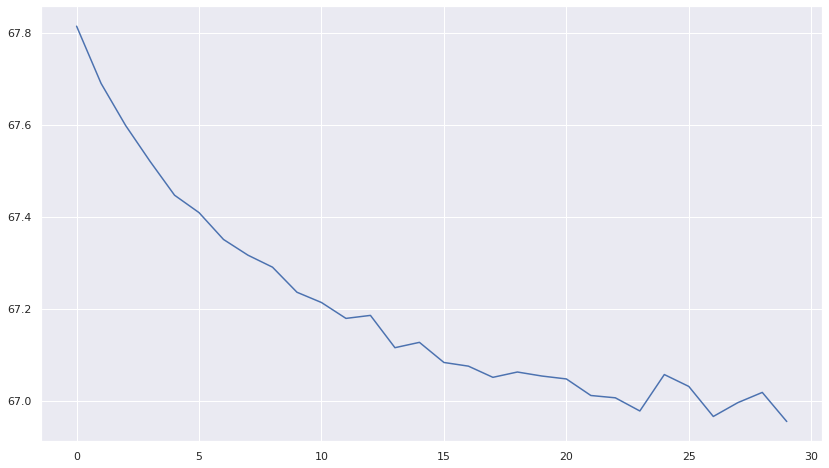

In [59]:
plt.figure(figsize=(14,8))
plt.plot(np.arange(0,EPOCH),history3.history['loss'], label='loss')
plt.show()

In [113]:
def predict(data):
    
    _timelag = time_lag_encoder[data[0]][data[1]]
    if type(_timelag) != list:
        _timelag = [0,0,0,0,0]
    
    
    _shoprank = shop_encoder[data[0]] if data[0] in shop_encoder else 0
    _categoryrank = category_encoder[data[1]] if data[1] in category_encoder else 0
    _itemprice = price_encoder[data[1]] if data[1] in price_encoder else 0
        
    _x = np.asarray( [*_timelag,_shoprank,_categoryrank,_itemprice])
    _x = _x.reshape(-1,8,1)
    
    predicted = model3.predict(_x)
    
    return predicted
    

In [114]:
pred = predict([5,5037])
pred[0][0]


3.5030885

In [115]:
def predict_test_set(row):
    row['item_cnt_month'] = predict([row['shop_id'],row['item_id']])[0][0]
    return row
submission_df = test.apply(predict_test_set, axis=1)

In [116]:
submission_df

ID  shop_id  item_id  item_cnt_month
0            0.0      5.0   5037.0        3.503088
1            1.0      5.0   5320.0        0.000000
2            2.0      5.0   5233.0        3.490409
3            3.0      5.0   5232.0        3.921205
4            4.0      5.0   5268.0        0.000000
...          ...      ...      ...             ...
214195  214195.0     45.0  18454.0        2.917502
214196  214196.0     45.0  16188.0       11.690527
214197  214197.0     45.0  15757.0        2.917645
214198  214198.0     45.0  19648.0        2.857635
214199  214199.0     45.0    969.0        2.989142

[214200 rows x 4 columns]

In [118]:
submission = submission_df.drop(columns=['shop_id','item_id'])
submission['ID'] = submission['ID'].astype(int) 

In [120]:
submission.to_csv('../data/submission.csv',index = False)

In [121]:
submission

ID  item_cnt_month
0            0        3.503088
1            1        0.000000
2            2        3.490409
3            3        3.921205
4            4        0.000000
...        ...             ...
214195  214195        2.917502
214196  214196       11.690527
214197  214197        2.917645
214198  214198        2.857635
214199  214199        2.989142

[214200 rows x 2 columns]